In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import utilities as util
import ast
import numpy as np
import dataframe_image as dfi

In [ ]:
#configurations
pd.set_option('display.max_colwidth', None)

In [3]:
def get_dataset_list(directory_path = "results-27-4-25"):
    """
    Get the list of datasets from the configuration file.
    """
    files = util.get_files_in_directory(directory_path)
    return files
print(get_dataset_list(directory_path = "results-04-05-25"))

Directory 'results-04-05-25' not found.
[]


In [4]:
def extract_data_from_file(file_name,directory_path = "results-27-4-25"):
    csv_path = os.path.join(directory_path,  file_name)
    # df = pd.read_csv(csv_path)
    df = pd.read_csv(csv_path)
    return df

In [5]:
def add_true_positives_column(df):
    """
    Adds a 'true_positives' column that counts words that were:
    1. Predicted as True in the predictions dictionary
    2. Actually present in the associations list
    """
    # First ensure predictions and associations are proper Python objects, not strings
    df['predictions'] = df['predictions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['associations'] = df['associations'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    # Function to count true positives for a single row
    def count_true_positives(row):
        # Get words predicted as True
        predictions_dict = row['predictions']
        positive_predictions = [word.lower() for word, is_true in predictions_dict.items() if is_true]
        
        # Get actual associations (lowercase for case-insensitive comparison)
        associations = [word.lower() for word in row['associations']]
        
        # Count the intersection (words that appear in both lists)
        true_positives = sum(1 for word in positive_predictions if word in associations)
        
        return true_positives
    
    # Apply the function to each row to create the new column
    df['true_positives'] = df.apply(count_true_positives, axis=1)
    
    return df

In [6]:
def add_false_positives_column(df):
    """
    Adds a 'false_positives' column that counts words that were:
    1. Predicted as True in the predictions dictionary
    2. NOT present in the associations list
    """
    # First ensure predictions and associations are proper Python objects, not strings
    df['predictions'] = df['predictions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['associations'] = df['associations'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    # Function to count false positives for a single row
    def count_false_positives(row):
        # Get words predicted as True
        predictions_dict = row['predictions']
        positive_predictions = [word.lower() for word, is_true in predictions_dict.items() if is_true]
        
        # Get actual associations (lowercase for case-insensitive comparison)
        associations = [word.lower() for word in row['associations']]
        
        # Count words predicted as True but not in associations (false positives)
        false_positives = sum(1 for word in positive_predictions if word not in associations)
        
        return false_positives
    
    # Apply the function to each row to create the new column
    df['false_positives'] = df.apply(count_false_positives, axis=1)
    
    return df

In [7]:
def add_true_negatives_column(df):
    """
    Adds a 'true_negatives' column that counts words that were:
    1. Predicted as False in the predictions dictionary
    2. NOT present in the associations list
    """
    # First ensure predictions and associations are proper Python objects, not strings
    df['predictions'] = df['predictions'].apply(lambda x: util.string_to_dict(x) if isinstance(x, str) else x)
    df['associations'] = df['associations'].apply(lambda x: util.string_to_list(x) if isinstance(x, str) else x)
    
    # Function to count true negatives for a single row
    def count_true_negatives(row):
        # Get words predicted as False
        predictions_dict = row['predictions']
        negative_predictions = [word.lower() for word, is_true in predictions_dict.items() if not is_true]
        
        # Get actual associations (lowercase for case-insensitive comparison)
        associations = [word.lower() for word in row['associations']]
        
        # Count words predicted as False that are not in associations (true negatives)
        true_negatives = sum(1 for word in negative_predictions if word not in associations)
        
        return true_negatives
    
    # Apply the function to each row to create the new column
    df['true_negatives'] = df.apply(count_true_negatives, axis=1)
    
    return df

In [8]:
def add_false_negatives_column(df):
    """
    Adds a 'false_negatives' column that counts words that were:
    1. Predicted as False in the predictions dictionary
    2. BUT actually present in the associations list
    """
    # First ensure predictions and associations are proper Python objects, not strings
    df['predictions'] = df['predictions'].apply(lambda x: util.string_to_dict(x) if isinstance(x, str) else x)
    df['associations'] = df['associations'].apply(lambda x: util.string_to_list(x) if isinstance(x, str) else x)
    
    # Function to count false negatives for a single row
    def count_false_negatives(row):
        # Get words predicted as False
        predictions_dict = row['predictions']
        # print(predictions_dict)
        negative_predictions = [word.lower() for word, is_true in predictions_dict.items() if not is_true]
        
        # Get actual associations (lowercase for case-insensitive comparison)
        associations = [word.lower() for word in row['associations']]
        
        # Count words predicted as False that are in associations (false negatives)
        false_negatives = sum(1 for word in negative_predictions if word in associations)
        
        return false_negatives
    
    # Apply the function to each row to create the new column
    df['false_negatives'] = df.apply(count_false_negatives, axis=1)
    
    return df

In [9]:
def clean_and_fix_data(df):
    new_head_titles = [ 
    "target_word",
    "predictions",
    "associations",
    "assoc_accuracy %",
    "predictions_count",
    "Baseline False Accuracy %",
    "predictions-clasify_as_true",
    "TP_success_rate %",
    "TN_success_rate %"]
    # Rename dataframe columns using the new_head_titles list
    df.columns = new_head_titles
    
    # Convert percentage columns to float
    for col in ["assoc_accuracy %", "Baseline False Accuracy %", "TP_success_rate %", "TN_success_rate %"]:
        df[col] = df[col].str.replace('%', '').astype(float)

    df['associations_count'] = df['associations'].apply(lambda x: util.count_list(eval(x) if isinstance(x, str) else x))
    df["predictions-clasify_as_false"] = df["predictions_count"] - df["predictions-clasify_as_true"]
    df['TN_success_rate %'] = df['TN_success_rate %'].fillna(0)
    df['TP_success_rate %'] = df['TP_success_rate %'].fillna(0)

    # Add the true positives column to the dataframe
    df = add_true_positives_column(df)
    df = add_false_positives_column(df)
    df = add_true_negatives_column(df)
    df = add_false_negatives_column(df)

    return df

In [10]:
def aclculate_metrics(df):
    
    TP = df['true_positives'].sum()
    FP = df['false_positives'].sum()
    TN = df['true_negatives'].sum()
    FN = df['false_negatives'].sum()

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    baseline_accuracy = (FP + TN)/(TP + FP + TN + FN)#df['predictions_count'].sum() if df['predictions_count'].sum() > 0 else 0

    return {"TP": TP, "FP": FP, "TN": TN, "FN": FN,
            "accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1_score, "baseline_false_accuracy": baseline_accuracy}


In [11]:
def add_avg_score():
    avg_score = extract_data_from_file(file_name = "benchmark_avg.csv", directory_path = "benchmarks")
    # Clean up the Score column and add a normalized version
    avg_score['Score'] = avg_score['Score'].fillna("0%")
    avg_score['Score'] = avg_score['Score'].apply(lambda x: float(x.replace('%', '')) / 100 if not pd.isna(x) else 0)
    return avg_score[["Model","Score"]]


In [12]:
def read_benchmark():
    """
    Read the benchmark_avg.xsl file and extract the average column.
    Returns a DataFrame with Model and Score columns.
    """
    
    # Read the Excel file
    file_path = os.path.join("benchmarks", "benchmark_normalized_filled_v2.csv")
    
    try:
        avg_score = pd.read_csv(file_path)
        
        # Check which columns exist and determine which one has the average values
        if 'avg' in avg_score.columns:
            score_column = 'avg'
        else:
            print(f"Available columns: {avg_score.columns.tolist()}")
            print("Could not find average column, please specify the correct column name")
            return pd.DataFrame(columns=["Model", "Score"])
        
        # Clean up the Score column and normalize values
        avg_score[score_column] = avg_score[score_column].fillna("0")
        avg_score[score_column] = avg_score[score_column].apply(
            lambda x: float(str(x).replace('%', '')) if not pd.isna(x) else 0
        )
        
        # Find the column that contains model names
        if 'Model' in avg_score.columns:
            model_column = 'Model'
        else:
            # Assume first column contains model names
            model_column = avg_score.columns[0]
            print(f"Using {model_column} as the model identifier column")
        
        # Return just the model and score columns
        return avg_score[[model_column, score_column]].rename(
            columns={model_column: "Model", score_column: "Score"}
        )
        
    except Exception as e:
        print(f"Error reading Excel file: {e}")
        return pd.DataFrame(columns=["Model", "Score"])

In [13]:
files = get_dataset_list(directory_path = "results-04-05-25")
print(files)
data = {}
df_list = {}
avg_score_list = read_benchmark()

for file_name in files:
    base_name, extension = os.path.splitext(file_name)

    # print("\nProcessing file:", base_name)
    # Extract data from the file
    df = extract_data_from_file(file_name, directory_path = "results-04-05-25")

    # Clean and fix the data
    df = clean_and_fix_data(df)

    df_list[base_name] = df
    # display(df_list)
    metrics = aclculate_metrics(df)
    metrics["avg_benchmarks_Score"] = avg_score_list[avg_score_list["Model"] == base_name]["Score"].values[0] if not avg_score_list[avg_score_list["Model"] == base_name].empty else None
    # metrics["model"] = base_name
    # print(add_avg_score())

    # print("Metrics for file", base_name, ":")
    data[base_name] = metrics

    
    
    # for x in metrics.items():
    #     print(x[0], ":", x[1])



Directory 'results-04-05-25' not found.
[]


In [14]:
benchmarks = pd.read_csv("benchmarks/benchmarks_with_rasch.csv")

# display(benchmarks)

In [15]:
experiment_1 = pd.read_csv('experiment_1.csv')
experiment_2 = pd.read_csv('experiment_2.csv')
experiment_3 = pd.read_csv('experiment_3.csv')
# display(experiment_1['model'])

merged_df = pd.merge(
    experiment_1,
    benchmarks[["model", "Ability (θ)"]],
    on="model",
    how="inner"
)

merged_df = merged_df.rename(columns={"Ability (θ)": "Rasch benchmarks"})
merged_df['Rasch benchmarks'] = merged_df['Rasch benchmarks']+0.5
merged_df['avg_benchmarks_Score'] = merged_df['Rasch benchmarks']
experiment_1 = merged_df

display(experiment_1)
display(experiment_2.info())
display(experiment_3)

,model,TP,FP,TN,FN,accuracy,precision,recall,f1_score,baseline_false_accuracy,avg_benchmarks_Score,Rasch benchmarks
0,anthropic-claude-3.7-sonnet-thinking,353,711,710,1,0.598873,0.331767,0.997175,0.497884,0.800563,1.814551,1.814551
1,anthropic-claude-3.5-haiku,273,1241,269,0,0.303982,0.180317,1.000000,0.305540,0.846887,0.353270,0.353270
2,deepseek-deepseek-chat-v3,326,1064,343,9,0.384041,0.234532,0.973134,0.377971,0.807692,1.026966,1.026966
3,deepseek-deepseek-r1,49,130,75,0,0.488189,0.273743,1.000000,0.429825,0.807087,1.721680,1.721680
4,google-gemini-2.5-flash-preview,301,1234,244,0,0.306352,0.196091,1.000000,0.327887,0.830804,1.790027,1.790027
5,google-gemini-2.5-pro-preview,383,946,453,0,0.469136,0.288187,1.000000,0.447430,0.785073,2.164194,2.164194
6,meta-llama-llama-3.1-8b-instruct,299,1080,343,23,0.367908,0.216824,0.928571,0.351558,0.815473,-0.341314,-0.341314
7,meta-llama-llama-4-scout,379,1023,262,1,0.384985,0.270328,0.997368,0.425365,0.771772,0.565294,0.565294
8,meta-llama-llama-3.2-3b-instruct,254,883,553,24,0.470828,0.223395,0.913669,0.359011,0.837806,-0.685893,-0.685893
9,mistralai-mistral-small-3.1-24b-instruct,296,1154,331,1,0.351852,0.204138,0.996633,0.338867,0.833333,0.137102,0.137102


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   model                 15 non-null     object 
 1   consistent_answers    15 non-null     int64  
 2   consistency_rate      15 non-null     float64
 3   overcuteness          15 non-null     int64  
 4   overcuteness_rate     15 non-null     float64
 5   provision_failure     15 non-null     int64  
 6   verification_failure  15 non-null     int64  
 7   total_failures_rate   15 non-null     float64
dtypes: float64(3), int64(4), object(1)
memory usage: 1.1+ KB


None

,model_name,failed_to_order,have_score,correct_individual_answers_count,total_answered_questions,avg_question_order_score,adjusted_avg_question_order_score,group_individual_duration_avg,group_individual_duration_std,group_individual_duration_std_percentage,group_individual_duration_std_percentage_median,combined_duration_avg,combined_duration_std
0,qwen/qwen-2.5-7b-instruct,3,247,691,1000,0.600540,0.607834,292.506000,135.982075,0.447829,0.436050,308.604000,90.842018
1,google/gemini-2.5-flash-preview,0,250,696,1000,0.676667,0.676667,1688.928000,2606.143693,0.793060,0.690027,1284.780000,501.746664
2,google/gemini-2.5-pro-preview,14,236,830,944,0.710452,0.752597,2738.866740,1853.964057,0.592662,0.540213,5547.737288,2484.729651
3,openai/o4-mini,0,250,861,1000,0.673333,0.673333,461.824580,273.324389,0.533337,0.488096,960.892000,359.803215
4,openai/gpt-4.1,1,249,883,1000,0.734270,0.737219,536.547000,714.048273,0.539372,0.428505,470.200000,96.293352
5,openai/gpt-4.1-mini,0,250,880,1000,0.704000,0.704000,274.173000,167.252314,0.563538,0.532192,534.992000,107.740727
6,mistralai/mistral-7b-instruct,63,187,504,1000,0.549020,0.733983,322.258000,288.077790,0.547520,0.515394,333.912000,101.628073
7,mistralai/mistral-small-3.1-24b-instruct,6,244,803,1000,0.599044,0.613774,292.021000,134.716397,0.432727,0.402310,338.548000,81.367922
8,anthropic/claude-3.7-sonnet-thinking,20,230,813,920,0.747826,0.812854,3233.643665,3601.199900,0.995522,1.023823,4764.221739,2595.280192
9,anthropic/claude-3.5-haiku,0,250,761,1000,0.674667,0.674667,259.021000,49.995558,0.189060,0.169755,279.116000,24.311040


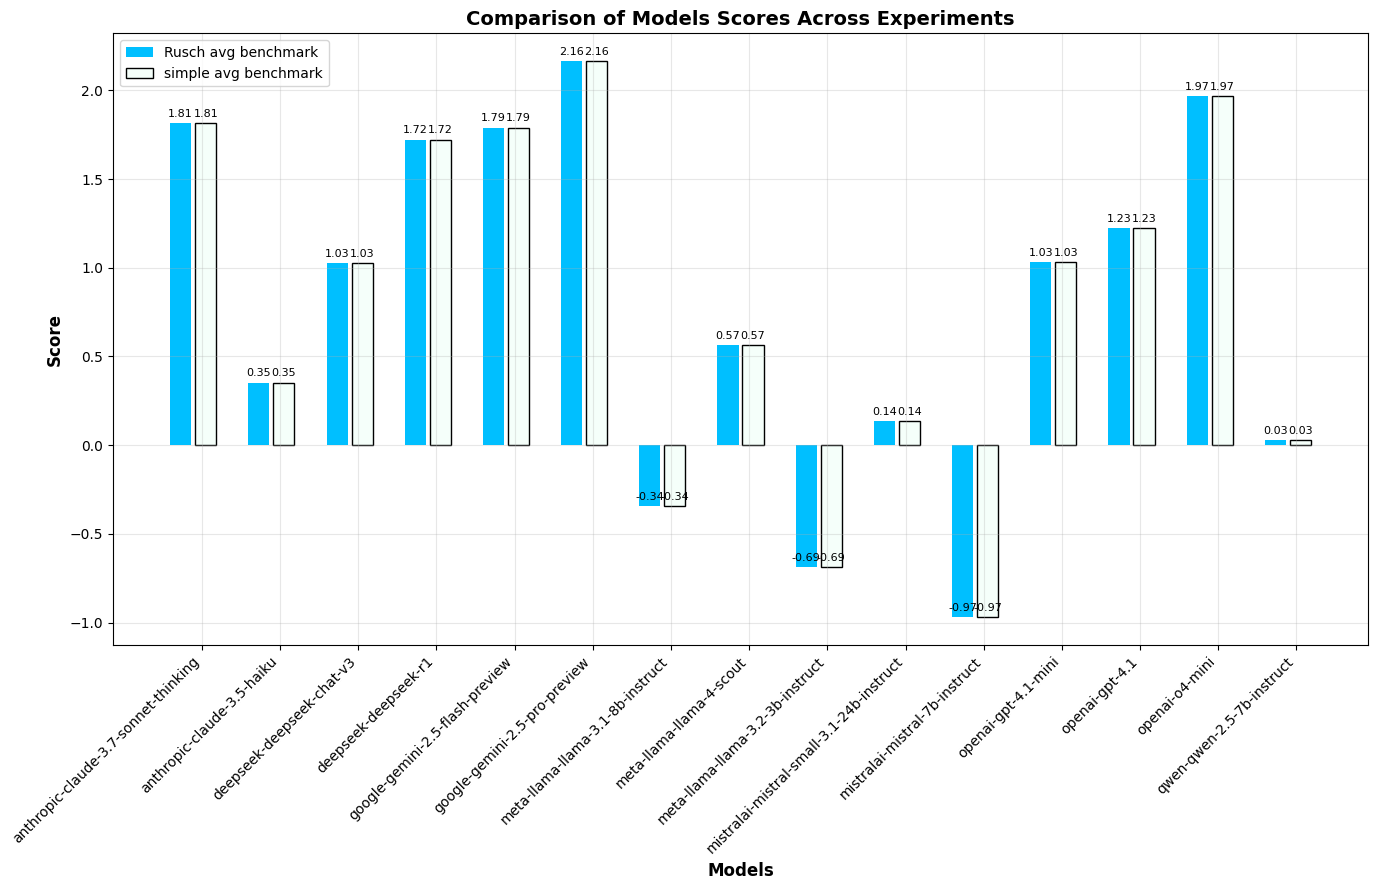

In [16]:
# Create the plot
fig, ax = plt.subplots(figsize=(14, 9))

# Set width of bars
barWidth = 0.27
positions = np.arange(len(experiment_1))

# Create bars
bars1 = ax.bar(positions - barWidth, experiment_1['Rasch benchmarks'], barWidth,
                label='Rusch avg benchmark', color='deepskyblue')

bars2 = ax.bar(positions+0.05, experiment_1['avg_benchmarks_Score'], barWidth, 
            label='simple avg benchmark', color='mintcream',edgecolor='black')

# Add labels, title and legend
ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('Comparison of Models Scores Across Experiments', fontweight='bold', fontsize=14)
ax.set_xticks(positions)
ax.set_xticklabels(experiment_1['model'], rotation=45, ha='right')
ax.legend()

# Add value labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

add_labels(bars1)
add_labels(bars2)


plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

## Experiment 1: Word Association Prediction Performance

Experiment 1 examines the ability of various LLMs to predict word associations. The experiment evaluates 15 different models including offerings from OpenAI, Google, Anthropic, Meta, DeepSeek, Mistral, and Qwen.

### Key Metrics
- **Accuracy**: The proportion of correct predictions (TP + TN) among all predictions
- **Precision**: The proportion of true positive predictions among all positive predictions
- **Recall**: The proportion of true positive predictions among all actual positives
- **F1-Score**: The harmonic mean of precision and recall
- **Baseline False Accuracy**: Performance baseline when predicting everything as false

### Key Findings
- **Best Overall Accuracy**: OpenAI O4-Mini (62.8%), followed by Anthropic Claude 3.7 Sonnet (59.9%)
- **Highest Recall**: Several models achieved perfect or near-perfect recall (>99%), including multiple OpenAI models, Google models, and Anthropic Claude 3.5
- **Precision Challenge**: All models struggled with precision, with the best being OpenAI O4-Mini at only 32.5%
- **F1-Score Performance**: OpenAI O4-Mini led with 49%, followed by Anthropic Claude 3.7 (49.8%)
- **Benchmark Correlation**: Models with higher benchmark scores generally performed better in the word association task, though some exceptions exist

### Performance Pattern
The results indicate most models excel at identifying true associations (high recall) but struggle with false positive predictions. This suggests a tendency to over-predict associations rather than miss actual ones.

In [17]:
display(experiment_1[['model',"accuracy",	"precision",	"recall",	"f1_score",	"baseline_false_accuracy"]])

,model,accuracy,precision,recall,f1_score,baseline_false_accuracy
0,anthropic-claude-3.7-sonnet-thinking,0.598873,0.331767,0.997175,0.497884,0.800563
1,anthropic-claude-3.5-haiku,0.303982,0.180317,1.000000,0.305540,0.846887
2,deepseek-deepseek-chat-v3,0.384041,0.234532,0.973134,0.377971,0.807692
3,deepseek-deepseek-r1,0.488189,0.273743,1.000000,0.429825,0.807087
4,google-gemini-2.5-flash-preview,0.306352,0.196091,1.000000,0.327887,0.830804
5,google-gemini-2.5-pro-preview,0.469136,0.288187,1.000000,0.447430,0.785073
6,meta-llama-llama-3.1-8b-instruct,0.367908,0.216824,0.928571,0.351558,0.815473
7,meta-llama-llama-4-scout,0.384985,0.270328,0.997368,0.425365,0.771772
8,meta-llama-llama-3.2-3b-instruct,0.470828,0.223395,0.913669,0.359011,0.837806
9,mistralai-mistral-small-3.1-24b-instruct,0.351852,0.204138,0.996633,0.338867,0.833333


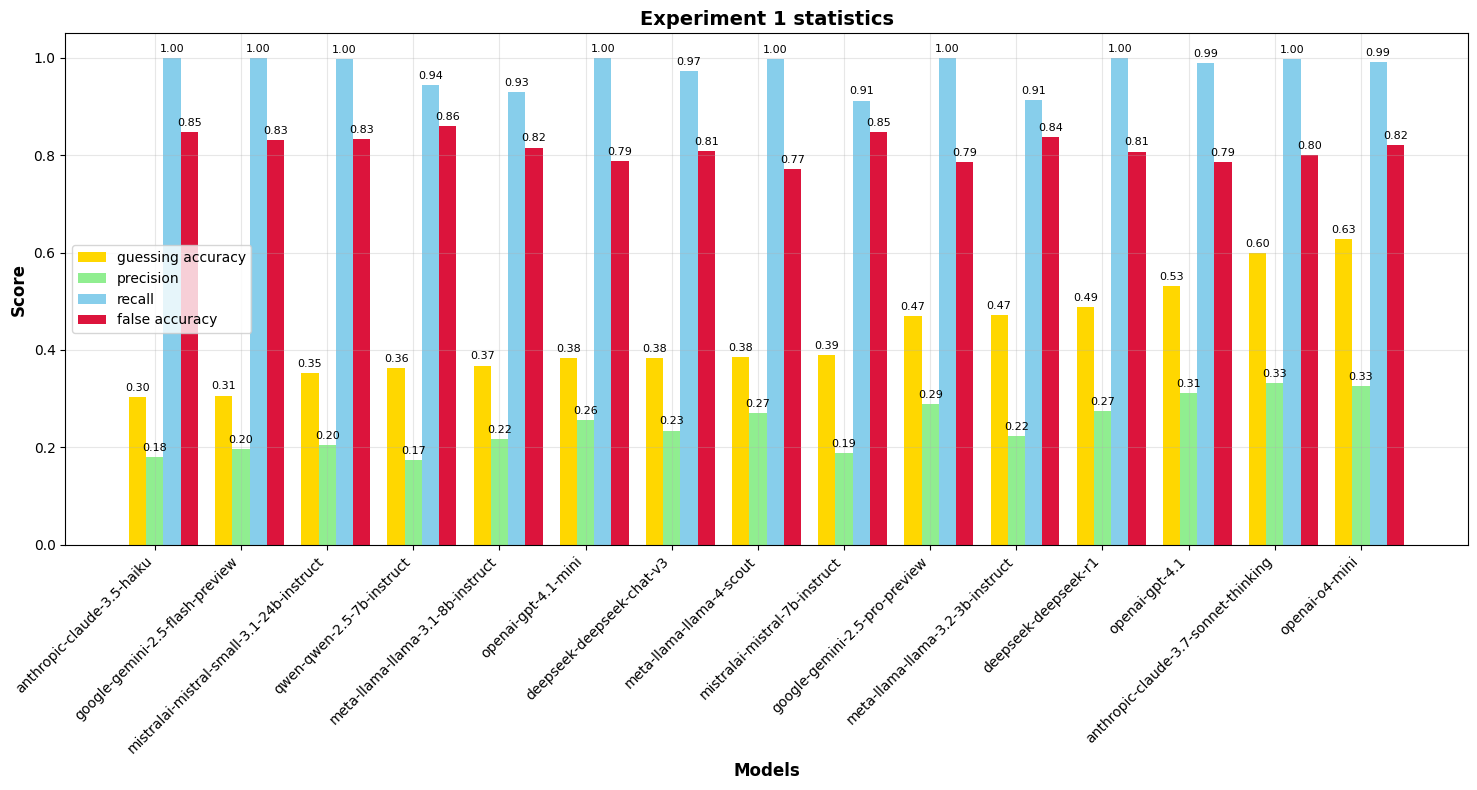

In [18]:
# Sort the merged data by avg_Score for better visualization
merged_exp = experiment_1.sort_values(by='accuracy', ascending=True)

# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Set width of bars
barWidth = 0.20
positions = np.arange(len(merged_exp))

# Create bars
bars1 = ax.bar(positions - barWidth, merged_exp['accuracy'], barWidth, 
              label='guessing accuracy', color='gold')
bars2 = ax.bar(positions, merged_exp['precision'], barWidth,
              label='precision', color='lightgreen')
bars3 = ax.bar(positions + barWidth, merged_exp['recall'], barWidth, 
              label='recall', color='skyblue')
bars4 = ax.bar(positions + 2*barWidth, merged_exp['baseline_false_accuracy'], barWidth, 
              label='false accuracy', color='crimson')

# Add labels, title and legend
ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('Experiment 1 statistics', fontweight='bold', fontsize=14)
ax.set_xticks(positions)
ax.set_xticklabels(merged_exp['model'], rotation=45, ha='right')
ax.legend()

# Add value labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# Merge the dataframes
# merged_df = pd.merge(experiment_2, experiment_1[['accuracy','avg_Score']], on='model', how='left')


merged_df = pd.merge(
    experiment_2[['model','consistency_rate', 'overcuteness_rate', 'total_failures_rate']],  # Select desired columns from experiment_2
    experiment_1[['model','accuracy', 'avg_benchmarks_Score']],  # Select desired columns from experiment_1
    on='model',  # Use the 'model' column from experiment_2 (the left DataFrame)
    how='left'
)
# # Save the merged dataframe to a CSV file
# merged_df.to_csv('merged_experiments.csv', index=False)



In [20]:
experiment_2.info()
display(experiment_2.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   model                 15 non-null     object 
 1   consistent_answers    15 non-null     int64  
 2   consistency_rate      15 non-null     float64
 3   overcuteness          15 non-null     int64  
 4   overcuteness_rate     15 non-null     float64
 5   provision_failure     15 non-null     int64  
 6   verification_failure  15 non-null     int64  
 7   total_failures_rate   15 non-null     float64
dtypes: float64(3), int64(4), object(1)
memory usage: 1.1+ KB


,model,consistent_answers,consistency_rate,overcuteness,overcuteness_rate,provision_failure,verification_failure,total_failures_rate
0,openai-gpt-4.1-mini,395,0.877778,52,0.945455,0,0,0.000000
1,openai-o4-mini,403,0.895556,30,0.909091,1,13,0.031111
2,deepseek-deepseek-r1,316,0.702222,133,0.992537,0,0,0.000000


In [21]:
display(experiment_1)
experiment_1["baseline_positive_accuracy"] = (experiment_1["TP"] + experiment_1["FP"])/(experiment_1["TP"] + experiment_1["FP"] + experiment_1["TN"] + experiment_1["FN"])
display(experiment_1)

,model,TP,FP,TN,FN,accuracy,precision,recall,f1_score,baseline_false_accuracy,avg_benchmarks_Score,Rasch benchmarks
0,anthropic-claude-3.7-sonnet-thinking,353,711,710,1,0.598873,0.331767,0.997175,0.497884,0.800563,1.814551,1.814551
1,anthropic-claude-3.5-haiku,273,1241,269,0,0.303982,0.180317,1.000000,0.305540,0.846887,0.353270,0.353270
2,deepseek-deepseek-chat-v3,326,1064,343,9,0.384041,0.234532,0.973134,0.377971,0.807692,1.026966,1.026966
3,deepseek-deepseek-r1,49,130,75,0,0.488189,0.273743,1.000000,0.429825,0.807087,1.721680,1.721680
4,google-gemini-2.5-flash-preview,301,1234,244,0,0.306352,0.196091,1.000000,0.327887,0.830804,1.790027,1.790027
5,google-gemini-2.5-pro-preview,383,946,453,0,0.469136,0.288187,1.000000,0.447430,0.785073,2.164194,2.164194
6,meta-llama-llama-3.1-8b-instruct,299,1080,343,23,0.367908,0.216824,0.928571,0.351558,0.815473,-0.341314,-0.341314
7,meta-llama-llama-4-scout,379,1023,262,1,0.384985,0.270328,0.997368,0.425365,0.771772,0.565294,0.565294
8,meta-llama-llama-3.2-3b-instruct,254,883,553,24,0.470828,0.223395,0.913669,0.359011,0.837806,-0.685893,-0.685893
9,mistralai-mistral-small-3.1-24b-instruct,296,1154,331,1,0.351852,0.204138,0.996633,0.338867,0.833333,0.137102,0.137102


,model,TP,FP,TN,FN,accuracy,precision,recall,f1_score,baseline_false_accuracy,avg_benchmarks_Score,Rasch benchmarks,baseline_positive_accuracy
0,anthropic-claude-3.7-sonnet-thinking,353,711,710,1,0.598873,0.331767,0.997175,0.497884,0.800563,1.814551,1.814551,0.599437
1,anthropic-claude-3.5-haiku,273,1241,269,0,0.303982,0.180317,1.000000,0.305540,0.846887,0.353270,0.353270,0.849131
2,deepseek-deepseek-chat-v3,326,1064,343,9,0.384041,0.234532,0.973134,0.377971,0.807692,1.026966,1.026966,0.797933
3,deepseek-deepseek-r1,49,130,75,0,0.488189,0.273743,1.000000,0.429825,0.807087,1.721680,1.721680,0.704724
4,google-gemini-2.5-flash-preview,301,1234,244,0,0.306352,0.196091,1.000000,0.327887,0.830804,1.790027,1.790027,0.862844
5,google-gemini-2.5-pro-preview,383,946,453,0,0.469136,0.288187,1.000000,0.447430,0.785073,2.164194,2.164194,0.745791
6,meta-llama-llama-3.1-8b-instruct,299,1080,343,23,0.367908,0.216824,0.928571,0.351558,0.815473,-0.341314,-0.341314,0.790258
7,meta-llama-llama-4-scout,379,1023,262,1,0.384985,0.270328,0.997368,0.425365,0.771772,0.565294,0.565294,0.842042
8,meta-llama-llama-3.2-3b-instruct,254,883,553,24,0.470828,0.223395,0.913669,0.359011,0.837806,-0.685893,-0.685893,0.663361
9,mistralai-mistral-small-3.1-24b-instruct,296,1154,331,1,0.351852,0.204138,0.996633,0.338867,0.833333,0.137102,0.137102,0.813692


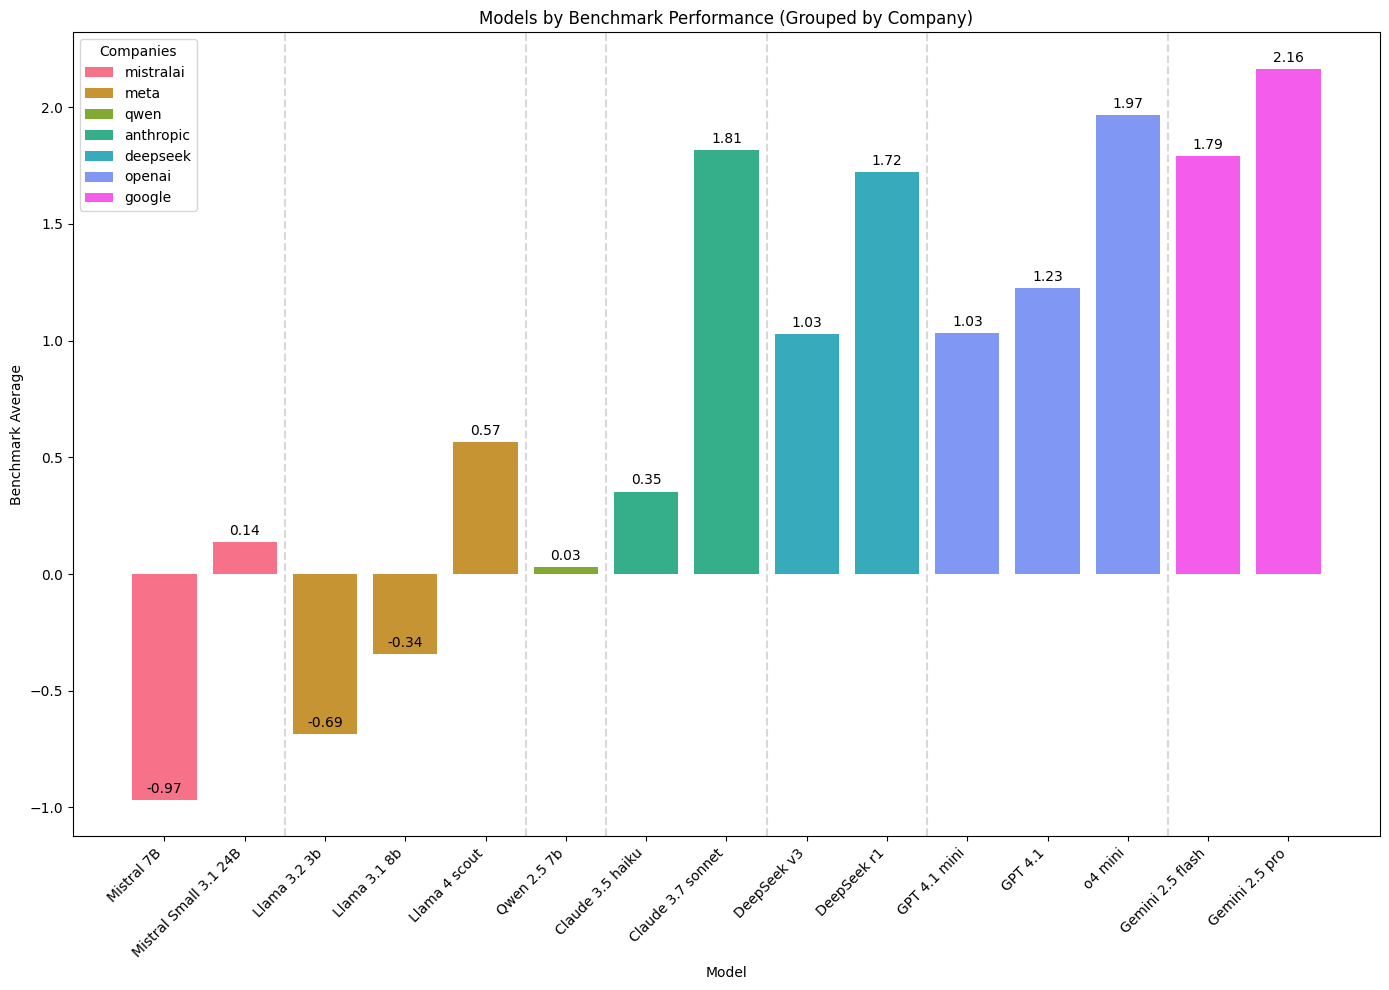

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_with_custom_order(sorted_df, company_order, model_col='model', benchmark_col='benchmark_avg'):
    """
    Create a bar plot showing benchmark averages with models grouped by company.
    """
    # Create a figure with appropriate size
    plt.figure(figsize=(14, 10))
    
    # Set up a color palette for companies
    company_colors = dict(zip(company_order, sns.color_palette("husl", len(company_order))))

    sorted_df["model"] = sorted_df["model"].apply(util.clean_model_name)
    
    # Create colors list based on company for each model
    colors = [company_colors[company] for company in sorted_df['company']]
    
    # Create the bar plot with the custom order
    bars = plt.bar(range(len(sorted_df)), sorted_df[benchmark_col], color=colors)
    
    # Set the x-tick positions and labels to match our custom order
    plt.xticks(range(len(sorted_df)), sorted_df[model_col], rotation=45, ha='right')
    
    # Add a legend for companies
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=company_colors[comp], label=comp) for comp in company_order]
    plt.legend(handles=legend_elements, title="Companies", loc='upper left')
    
    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')
    
    plt.xlabel('Model')
    plt.ylabel('Benchmark Average')
    plt.title('Models by Benchmark Performance (Grouped by Company)')
    
    # Add visual separators between company groups
    prev_company = None
    for i, company in enumerate(sorted_df['company']):
        if company != prev_company and i > 0:
            plt.axvline(x=i-0.5, color='gray', linestyle='--', alpha=0.3)
            prev_company = company
        elif i == 0:
            prev_company = company
    
    plt.tight_layout()
    plt.show()

    
sorted_models, company_order = util.sort_and_group_models(experiment_1,benchmark_col='Rasch benchmarks')
# sorted_models = sorted_models["model"]
plot_with_custom_order(sorted_models, company_order)

Model order mapping: {'Mistral 7B': 0, 'Mistral Small 3.1 24B': 1, 'Llama 3.2 3b': 2, 'Llama 3.1 8b': 3, 'Llama 4 scout': 4, 'Qwen 2.5 7b': 5, 'Claude 3.5 haiku': 6, 'Claude 3.7 sonnet': 7, 'DeepSeek v3': 8, 'DeepSeek r1': 9, 'GPT 4.1 mini': 10, 'GPT 4.1': 11, 'o4 mini': 12, 'Gemini 2.5 flash': 13, 'Gemini 2.5 pro': 14}
               model   TP    FP   TN  FN  accuracy  precision    recall  \
0  Claude 3.7 sonnet  353   711  710   1  0.598873   0.331767  0.997175   
1   Claude 3.5 haiku  273  1241  269   0  0.303982   0.180317  1.000000   
2        DeepSeek v3  326  1064  343   9  0.384041   0.234532  0.973134   

   f1_score  baseline_false_accuracy  avg_benchmarks_Score  Rasch benchmarks  \
0  0.497884                 0.800563              1.814551          1.814551   
1  0.305540                 0.846887              0.353270          0.353270   
2  0.377971                 0.807692              1.026966          1.026966   

   baseline_positive_accuracy  sort_index  
0           

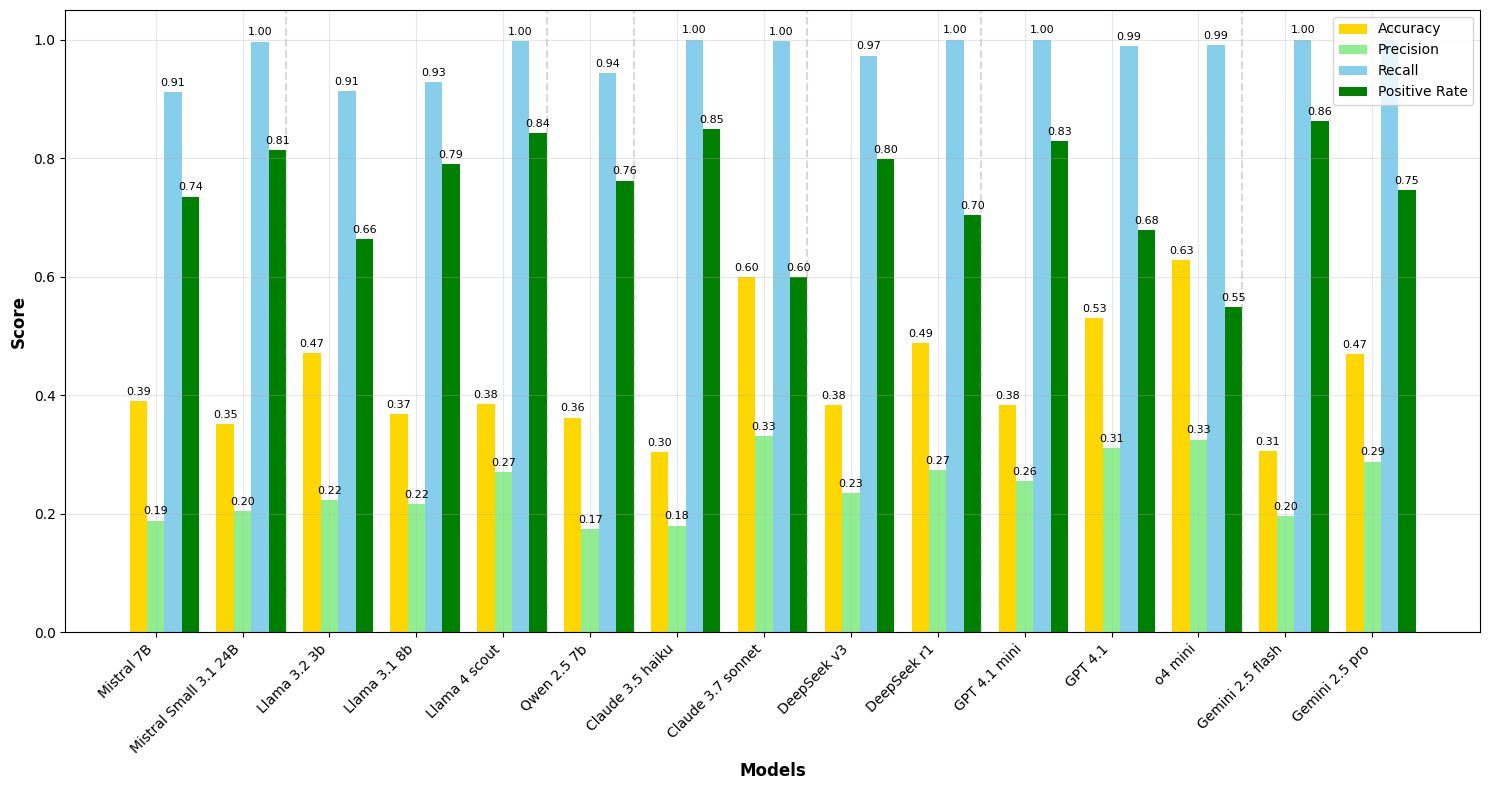

In [23]:
# Sort the merged data by avg_Score for better visualization

experiment_1_clean = experiment_1.copy()
experiment_1_clean["model"] = experiment_1["model"].apply(util.clean_model_name)


merged_exp = util.sort_dataframe_by_company_model_order(experiment_1_clean, sorted_models)

# Add company information to experiment_1
merged_exp = pd.merge(
    merged_exp,
    sorted_models[['model', 'company']],
    on='model',
    how='left'
)
# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))

# display(merged_exp)
# Set width of bars
barWidth = 0.20
positions = np.arange(len(merged_exp))

# Create bars
bars1 = ax.bar(positions - barWidth, merged_exp['accuracy'], barWidth, 
              label='Accuracy', color='gold')
bars2 = ax.bar(positions, merged_exp['precision'], barWidth,
               label='Precision', color='lightgreen')
bars3 = ax.bar(positions + barWidth, merged_exp['recall'], barWidth, 
               label='Recall', color='skyblue')
bars4 = ax.bar(positions + 2*barWidth, merged_exp['baseline_positive_accuracy'], barWidth, 
              label='Positive Rate', color='green')

# Add labels, title and legend
ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
# ax.set_title('Experiment 1 statistics', fontweight='bold', fontsize=14)
ax.set_xticks(positions)
ax.set_xticklabels(merged_exp['model'], rotation=45, ha='right')
ax.legend()

# Add value labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

prev_company = None
for i, company in enumerate(merged_exp['company']):
    if company != prev_company and i > 0:
        plt.axvline(x=i-0.5, color='gray', linestyle='--', alpha=0.3)
        prev_company = company
    elif i == 0:
        prev_company = company

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

### Experiment 3

In [24]:
display(experiment_3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 13 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   model_name                                       15 non-null     object 
 1   failed_to_order                                  15 non-null     int64  
 2   have_score                                       15 non-null     int64  
 3   correct_individual_answers_count                 15 non-null     int64  
 4   total_answered_questions                         15 non-null     int64  
 5   avg_question_order_score                         15 non-null     float64
 6   adjusted_avg_question_order_score                15 non-null     float64
 7   group_individual_duration_avg                    15 non-null     float64
 8   group_individual_duration_std                    15 non-null     float64
 9   group_individual_duration_std_perc

None

In [25]:
%pip install adjustText

Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_50831/3315797023.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax4.scatter(
/tmp/ipykernel_50831/3315797023.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend(loc='lower right', fontsize=10)


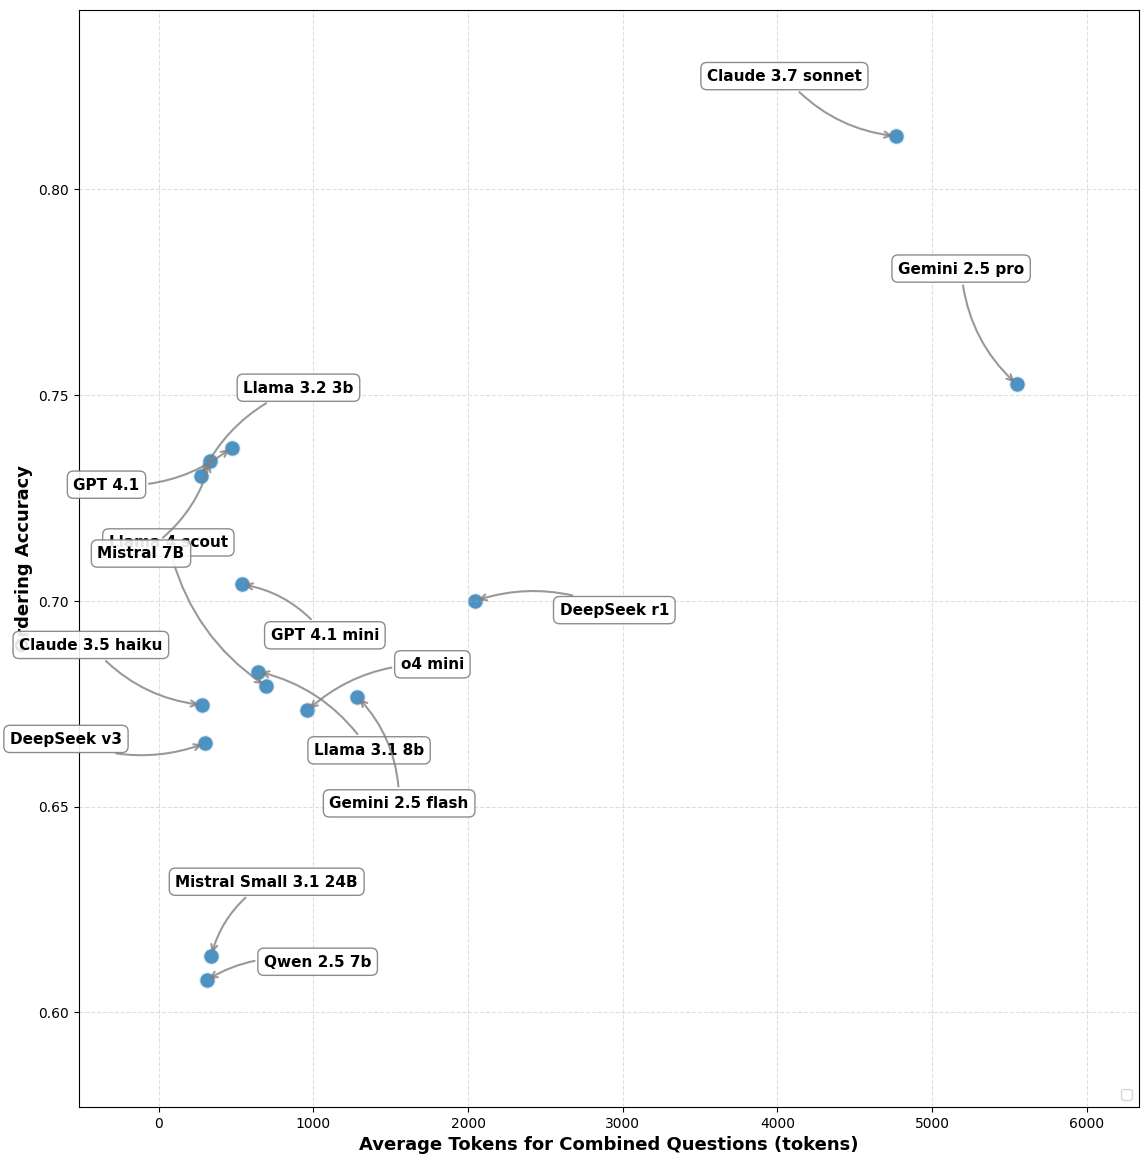

In [26]:
# Enhanced version with better label placement
fig4, ax4 = plt.subplots(figsize=(12, 12))  # Even larger figure for more space

experiment_3_clean = experiment_3.copy()
experiment_3_clean["model_name"] = experiment_3["model_name"].apply(util.clean_model_name)

# Sort by standard deviation to ensure points with higher values are on top
sorted_indices = experiment_3_clean['group_individual_duration_std'].argsort()
sorted_df = experiment_3_clean.iloc[sorted_indices]

# Create scatter plot
scatter = ax4.scatter(
    sorted_df['combined_duration_avg'], 
    sorted_df['adjusted_avg_question_order_score'],
    s=140,  # Larger markers
   
    cmap='plasma',
    alpha=0.8,
    edgecolors='white',
    linewidths=1.5  # Thicker edges
)

# More extreme offsets with greater variation to avoid overlap
# These are carefully positioned to avoid overlap based on your data points
offsets = [
    (-80, 40),   # Far left, higher
    (40, 50),    # Right, higher
    (80, 10),    # Far right, slightly higher
    (-70, 100),  # Far left, lower
    (60, -40),   # Right, lower
    (-100, 0),   # Far left, middle
    (90, 30),    # Far right, higher
    (-50, -70),  # Left, far lower
    (70, 60),    # Right, far higher
    (100, -10),  # Far right, slightly lower
    (-90, -30),  # Far left, lower
    (80, -60),   # Right, far lower
    (-40, 80),   # Left, far higher
    (30, -80),   # Right, far lower
]

# Use custom offsets for each point with optimized label placement
for i, model in enumerate(sorted_df['model_name']):
    short_name = model.split('/')[-1]
    offset_idx = i % len(offsets)
    
    # Add more white space around labels with larger padding
    ax4.annotate(short_name, 
                (sorted_df['combined_duration_avg'].iloc[i], 
                 sorted_df['adjusted_avg_question_order_score'].iloc[i]),
                xytext=offsets[offset_idx],
                textcoords="offset points",
                fontsize=11,  # Larger font
                fontweight='bold',
                ha='center',
                bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.9),  # More padding, higher opacity
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", 
                              color="gray", lw=1.5, alpha=0.8))  # Thicker arrows

# Add a regression line
x = sorted_df['combined_duration_avg']
y = sorted_df['adjusted_avg_question_order_score']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
#ax4.plot(x, p(x), "--", color='crimson', alpha=0.7, linewidth=2,
#        label=f"Trend: {z[0]:.2e}x + {z[1]:.2f}")

# Improve grid appearance
ax4.grid(True, linestyle='--', alpha=0.4)
ax4.legend(loc='lower right', fontsize=10)

# Better axis labels and title
ax4.set_xlabel('Average Tokens for Combined Questions (tokens)', fontsize=13, fontweight='bold')
ax4.set_ylabel('Ordering Accuracy', fontsize=13, fontweight='bold')
# ax4.set_title('Cost vs. Accuracy by Model', fontsize=15, fontweight='bold')

# Add some padding to the axes to ensure all labels fit
x_min, x_max = min(x), max(x)
y_min, y_max = min(y), max(y)
x_padding = (x_max - x_min) * 0.15  # 15% padding
y_padding = (y_max - y_min) * 0.15
ax4.set_xlim(x_min - x_padding, x_max + x_padding)
ax4.set_ylim(y_min - y_padding, y_max + y_padding)

# # Improved colorbar
# cbar = plt.colorbar(scatter, ax=ax4, pad=0.02)
# cbar.set_label('Standard Deviation Percentage', fontsize=11, fontweight='bold')
# cbar.ax.tick_params(labelsize=9)

plt.tight_layout(pad=2.0)  # More padding around the figure
plt.show()

In [27]:
def clean_model_name(model_name):
    """
    Clean model names to show only the essential model identifier.
    Examples:
    - "qwen-qwen-2.5-7b-instruct" -> "qwen 2.5 7b"
    - "anthropic-claude-3.5-haiku" -> "claude 3.5 haiku"
    - "google-gemini-2.5-flash-preview" -> "gemini 2.5 flash"
    """
    if pd.isna(model_name) or model_name == "":
        return model_name
   
    # Convert to lowercase for processing
    name = str(model_name).lower()
    name = name.replace('/', '-')
    # Remove common prefixes
    prefixes_to_remove = ['anthropic-', 'google-', 'openai-', 'meta-', 'deepseek-', 'mistralai-', 'qwen-',
                          'anthropic/', 'google/', 'openai/', 'meta/', 'deepseek/', 'mistralai/', 'qwen/']
    for prefix in prefixes_to_remove:
        if name.startswith(prefix):
            name = name[len(prefix):]
            break
    
    # Remove duplicate company names (e.g., "qwen-qwen-2.5" -> "qwen-2.5")
    parts = name.split('-')
    if len(parts) > 1 and parts[0] == parts[1]:
        parts = parts[1:]
        name = '-'.join(parts)
    
    # Remove common suffixes
    suffixes_to_remove = ['-instruct', '-chat', '-preview', '-thinking', '-001', '-0324', '-03-25']
    for suffix in suffixes_to_remove:
        if name.endswith(suffix):
            name = name[:-len(suffix)]
            break
    
    # Replace hyphens with spaces and clean up
    name = name.replace('-', ' ')
    
    # Remove extra words that don't add value
    words_to_remove = ['instruct', 'chat', 'preview', 'thinking']
    words = name.split()
    words = [word for word in words if word not in words_to_remove]
    
    # Join and capitalize appropriately
    cleaned_name = ' '.join(words)
    
    # Special handling for specific models
    if 'claude' in cleaned_name:
        cleaned_name = cleaned_name.replace('claude', 'Claude')
    elif 'gemini' in cleaned_name:
        cleaned_name = cleaned_name.replace('gemini', 'Gemini')
    elif 'gpt' in cleaned_name:
        cleaned_name = cleaned_name.replace('gpt', 'GPT')
    elif 'llama' in cleaned_name:
        cleaned_name = cleaned_name.replace('llama', 'Llama')
    elif 'qwen' in cleaned_name:
        cleaned_name = cleaned_name.replace('qwen', 'Qwen')
    elif 'mistral' in cleaned_name or 'mistralai' in cleaned_name:
        cleaned_name = cleaned_name.title()
    elif 'deepseek' in cleaned_name:
        cleaned_name = cleaned_name.replace('deepseek', 'DeepSeek')
    
    return cleaned_name



In [28]:
answer_rate_data = pd.read_csv('experiment_3.csv')
display(answer_rate_data.head(3))

answer_rate_data['correct_individual_answers_rate'] = answer_rate_data['correct_individual_answers_count'] / answer_rate_data['total_answered_questions']
answer_rate_data['failure_rate'] = answer_rate_data['total_answered_questions'] - answer_rate_data['correct_individual_answers_count']/ answer_rate_data['total_answered_questions']
display(answer_rate_data[['model_name', 'correct_individual_answers_rate']].head(3))

display(answer_rate_data[['model_name', 'correct_individual_answers_rate','adjusted_avg_question_order_score']])
mask = answer_rate_data[answer_rate_data['model_name'].isin(['google/gemini-2.5-pro-preview','openai/o4-mini','anthropic/claude-3.7-sonnet-thinking','deepseek/deepseek-r1'])]
print("reasoning average: ", mask['adjusted_avg_question_order_score'].mean())
print("non reasoning average: ", answer_rate_data[answer_rate_data['model_name'].isin(['openai/gpt-4.1','google/gemini-2.5-flash-preview','deepseek/deepseek-chat-v3','anthropic/claude-3.5-haiku'])]['adjusted_avg_question_order_score'].mean())

,model_name,failed_to_order,have_score,correct_individual_answers_count,total_answered_questions,avg_question_order_score,adjusted_avg_question_order_score,group_individual_duration_avg,group_individual_duration_std,group_individual_duration_std_percentage,group_individual_duration_std_percentage_median,combined_duration_avg,combined_duration_std
0,qwen/qwen-2.5-7b-instruct,3,247,691,1000,0.600540,0.607834,292.50600,135.982075,0.447829,0.436050,308.604000,90.842018
1,google/gemini-2.5-flash-preview,0,250,696,1000,0.676667,0.676667,1688.92800,2606.143693,0.793060,0.690027,1284.780000,501.746664
2,google/gemini-2.5-pro-preview,14,236,830,944,0.710452,0.752597,2738.86674,1853.964057,0.592662,0.540213,5547.737288,2484.729651


,model_name,correct_individual_answers_rate
0,qwen/qwen-2.5-7b-instruct,0.691000
1,google/gemini-2.5-flash-preview,0.696000
2,google/gemini-2.5-pro-preview,0.879237


,model_name,correct_individual_answers_rate,adjusted_avg_question_order_score
0,qwen/qwen-2.5-7b-instruct,0.691000,0.607834
1,google/gemini-2.5-flash-preview,0.696000,0.676667
2,google/gemini-2.5-pro-preview,0.879237,0.752597
3,openai/o4-mini,0.861000,0.673333
4,openai/gpt-4.1,0.883000,0.737219
5,openai/gpt-4.1-mini,0.880000,0.704000
6,mistralai/mistral-7b-instruct,0.504000,0.733983
7,mistralai/mistral-small-3.1-24b-instruct,0.803000,0.613774
8,anthropic/claude-3.7-sonnet-thinking,0.883696,0.812854
9,anthropic/claude-3.5-haiku,0.761000,0.674667


reasoning average:  0.734696302341254
non reasoning average:  0.6884714897071552


,model,correct_individual_answers_rate,avg_question_order_score,failed_to_order,adjusted_avg_question_order_score
0,qwen-qwen-2.5-7b-instruct,0.691000,0.600540,3,0.607834
1,google-gemini-2.5-flash-preview,0.696000,0.676667,0,0.676667
2,google-gemini-2.5-pro-preview,0.879237,0.710452,14,0.752597


Model order mapping: {'Mistral 7B': 0, 'Mistral Small 3.1 24B': 1, 'Llama 3.2 3b': 2, 'Llama 3.1 8b': 3, 'Llama 4 scout': 4, 'Qwen 2.5 7b': 5, 'Claude 3.5 haiku': 6, 'Claude 3.7 sonnet': 7, 'DeepSeek v3': 8, 'DeepSeek r1': 9, 'GPT 4.1 mini': 10, 'GPT 4.1': 11, 'o4 mini': 12, 'Gemini 2.5 flash': 13, 'Gemini 2.5 pro': 14}
              model  correct_individual_answers_rate  \
0       Qwen 2.5 7b                         0.691000   
1  Gemini 2.5 flash                         0.696000   
2    Gemini 2.5 pro                         0.879237   

   avg_question_order_score  failed_to_order  \
0                  0.600540                3   
1                  0.676667                0   
2                  0.710452               14   

   adjusted_avg_question_order_score  sort_index  
0                           0.607834           5  
1                           0.676667          13  
2                           0.752597          14  


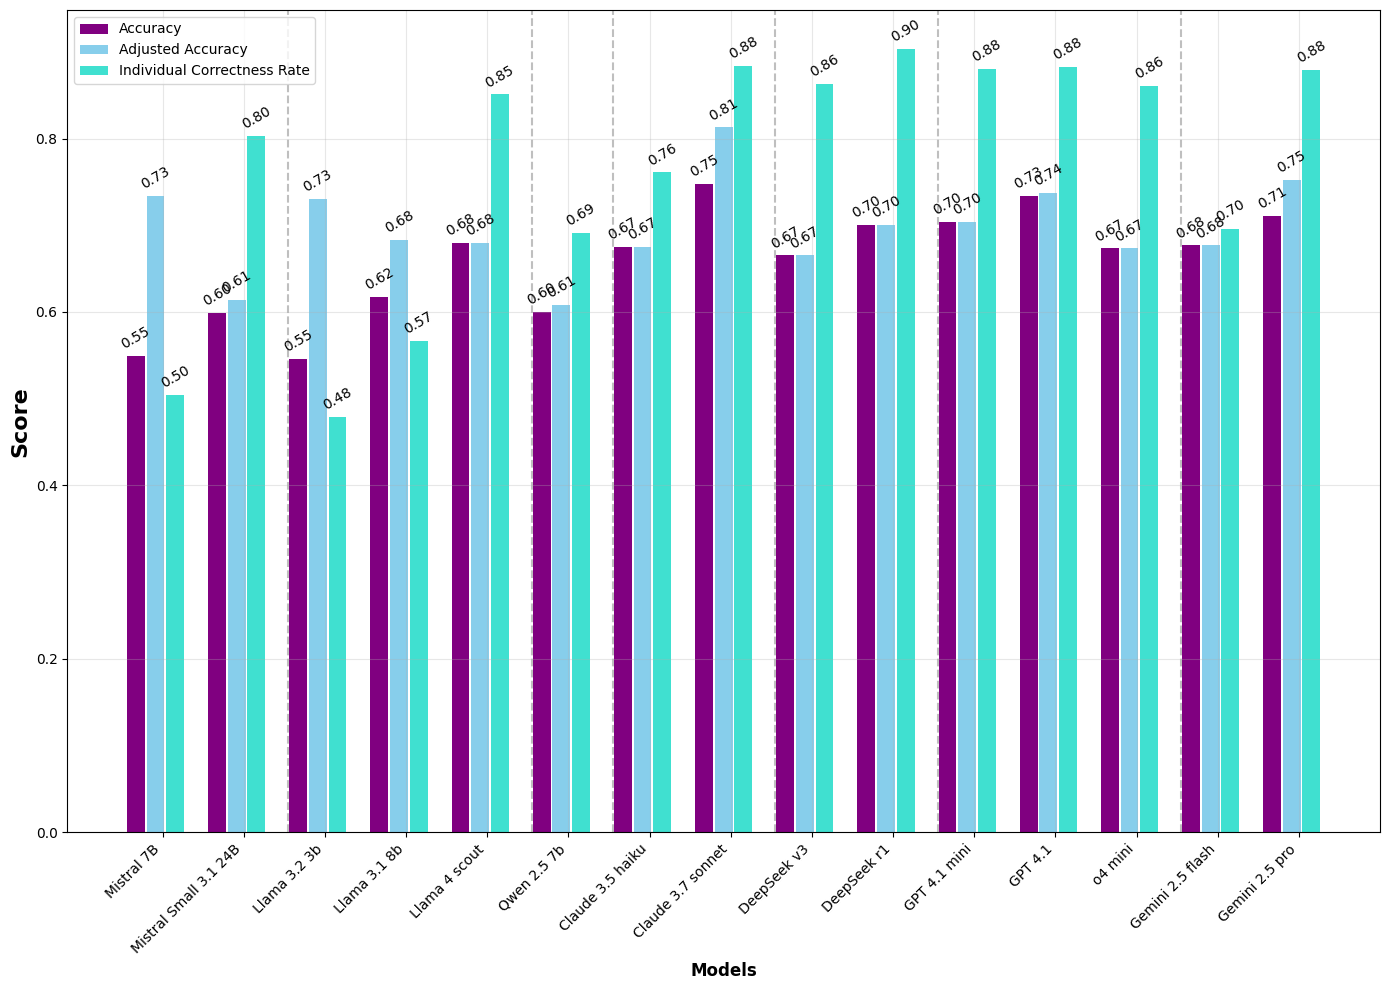

In [29]:
answer_rate_data['model'] = answer_rate_data['model_name'].str.replace('/', '-', regex=False)
# Merge the datasets based on model name
merged_exp = answer_rate_data[['model', 'correct_individual_answers_rate','avg_question_order_score','failed_to_order','adjusted_avg_question_order_score']]


display(merged_exp.head(3))
# Sort and add company information
merged_exp_clean = merged_exp.copy()
merged_exp_clean["model"] = merged_exp["model"].apply(util.clean_model_name)
# print(sorted_models)
merged_exp = util.sort_dataframe_by_company_model_order(merged_exp_clean, sorted_models, 'model')
merged_exp = pd.merge(
    merged_exp,
    sorted_models[['model', 'company']],
    on='model',
    how='left'
)
# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Set width of bars
barWidth = 0.33
positions = np.arange(len(merged_exp))*1.5
offset = 0.09  # Offset for the bars to avoid overlap

# First, draw vertical separator lines BEFORE creating the bars
# This ensures they appear behind the bars
companies = merged_exp['company'].values
company_change_indices = []

# Find where company changes occur
for i in range(1, len(companies)):
    if companies[i] != companies[i-1]:
        company_change_indices.append(i)

# Draw separator lines at the correct positions between company groups
for idx in company_change_indices:
    # Calculate the correct x-position between groups
    separator_x = positions[idx-1] + barWidth*4.0  # Position after the last bar of previous group
    plt.axvline(x=separator_x, color='gray', linestyle='--', alpha=0.5, zorder=0)

# Create bars
bars1 = ax.bar(positions, merged_exp['avg_question_order_score'], barWidth,
               label='Accuracy', color='purple')

bars3 = ax.bar(positions + barWidth*1.1, merged_exp['adjusted_avg_question_order_score'], barWidth, 
               label='Adjusted Accuracy', color='skyblue')

bars2 = ax.bar(positions + barWidth*2.2, merged_exp['correct_individual_answers_rate'], barWidth,
               label='Individual Correctness Rate', color='turquoise')



# bars4 = ax.bar(positions + barWidth*3.3, merged_exp['failed_to_order'], barWidth,
#                label='Avg benchmarks Score', color='salmon')

# Add labels, title and legend
ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=16)
# ax.set_title('Experiment 3 statistics', fontweight='bold', fontsize=14)
ax.set_xticks(positions + barWidth*1.5)  # Center the labels
ax.set_xticklabels(merged_exp['model'], rotation=45, ha='right')
ax.legend()

# Add value labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, rotation=30)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
# add_labels(bars4)

plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

In [30]:
# Create a comprehensive table showing model benchmarks and correct individual answer rates
# Create a comprehensive table showing model benchmarks and correct individual answer rates
# First, let's standardize the model names for proper matching
answer_rate_copy = answer_rate_data.copy()
answer_rate_copy['model'] = answer_rate_copy['model_name'].str.replace('/', '-', regex=False)

benchmark_answer_table = pd.merge(
    answer_rate_copy[['model', 'correct_individual_answers_rate']],
    experiment_1[['model', 'avg_benchmarks_Score']],
    on='model',
    how='inner'
)

# Round numerical values for better readability
benchmark_answer_table = benchmark_answer_table.round(3)

# Apply clean model names for better display
benchmark_answer_table['model'] = benchmark_answer_table['model'].apply(clean_model_name)

# Rename columns for clarity
benchmark_answer_table = benchmark_answer_table.rename(columns={
    'model': 'Model',
    'correct_individual_answers_rate': 'Individual Answer Rate',
    'avg_benchmarks_Score': 'Avg Benchmark Score'
})

display(benchmark_answer_table)

,Model,Individual Answer Rate,Avg Benchmark Score
0,Qwen 2.5 7b,0.691,0.031
1,Gemini 2.5 flash,0.696,1.790
2,Gemini 2.5 pro,0.879,2.164
3,o4 mini,0.861,1.967
4,GPT 4.1,0.883,1.226
5,GPT 4.1 mini,0.880,1.031
6,Mistral 7B,0.504,-0.968
7,Mistral Small 3.1 24B,0.803,0.137
8,Claude 3.7 sonnet,0.884,1.815
9,Claude 3.5 haiku,0.761,0.353


In [31]:
mask = benchmark_answer_table[benchmark_answer_table['Model'].isin(['Gemini 2.5 pro','o4 mini','Claude 3.7 sonnet','DeepSeek r1'])]
mask_comp = benchmark_answer_table['Model'].isin(['GPT 4.1','Gemini 2.5 flash','DeepSeek v3','Claude 3.5 haiku'])
print("reasoning average: ", mask['Individual Answer Rate'].mean())
print("non reasoning average: ", benchmark_answer_table[mask_comp]['Individual Answer Rate'].mean())
# print("\n\nperformance average\n")

# print("reasoning average: ", mask['performance_avg'].mean())
# print("non reasoning average: ", benchmark_answer_table[mask_comp]['performance_avg'].mean())


reasoning average:  0.88175
non reasoning average:  0.80075


Correlation between average benchmark score and individual question accuracy: 0.807


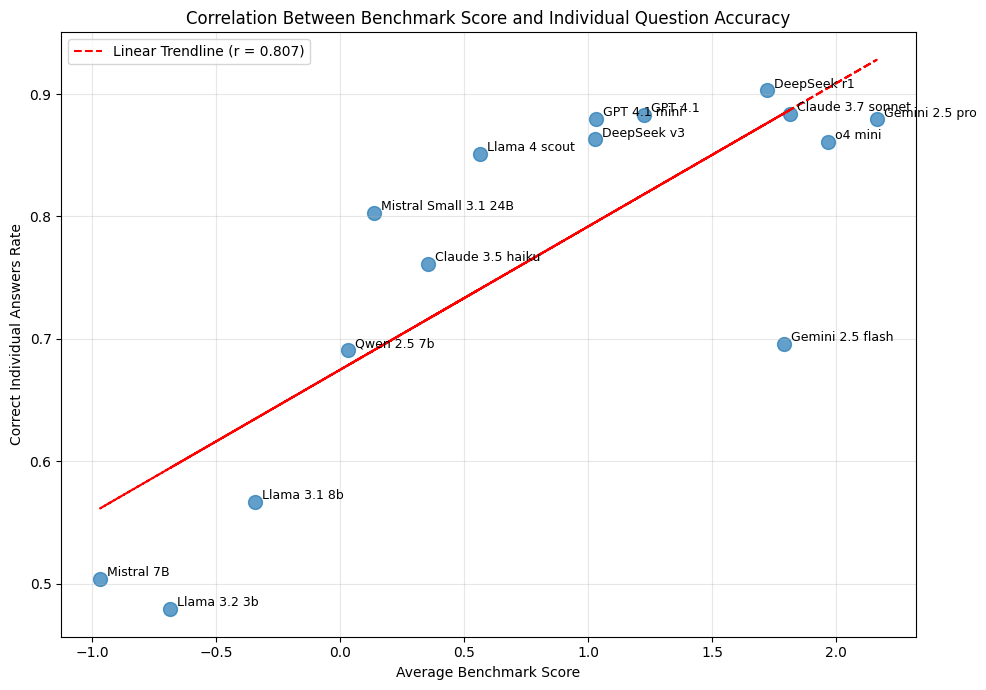

Correlation coefficient: 0.807


In [32]:
# Create a copy of answer_rate_data and add the properly formatted model column
answer_rate_analysis = answer_rate_data.copy()
answer_rate_analysis['model'] = answer_rate_analysis['model_name'].str.replace('/', '-', regex=False)



# Merge with benchmark data from experiment_1 (which contains avg_benchmarks_Score)
merged_answer_benchmarks = pd.merge(
    answer_rate_analysis[['model', 'correct_individual_answers_rate']],
    experiment_1[['model', 'avg_benchmarks_Score']],
    on='model', how='inner'
)

# Apply the clean_model_name function to make model names more readable
merged_answer_benchmarks['model'] = merged_answer_benchmarks['model'].apply(clean_model_name)

# Calculate correlation
correlation = merged_answer_benchmarks['correct_individual_answers_rate'].corr(
    merged_answer_benchmarks['avg_benchmarks_Score']    
)

print(f"Correlation between average benchmark score and individual question accuracy: {correlation:.3f}")

# Create scatter plot
plt.figure(figsize=(10, 7))
x = merged_answer_benchmarks['avg_benchmarks_Score']
y = merged_answer_benchmarks['correct_individual_answers_rate']

# Add scatter points
plt.scatter(x, y, s=100, alpha=0.7)

# Add model name labels
for i, row in merged_answer_benchmarks.iterrows():
    plt.annotate(row['model'], 
                (row['avg_benchmarks_Score'], row['correct_individual_answers_rate']),
                fontsize=9, xytext=(5, 2), textcoords='offset points')

# Add regression line
coefs = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coefs)
plt.plot(x, poly1d_fn(x), color='red', linestyle='--', 
         label=f'Linear Trendline (r = {correlation:.3f})')

# Add labels and title
plt.xlabel('Average Benchmark Score')
plt.ylabel('Correct Individual Answers Rate')
plt.title('Correlation Between Benchmark Score and Individual Question Accuracy')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Correlation coefficient: {correlation:.3f}")

                    model   TP    FP   TN  FN  accuracy  precision    recall  \
10             Mistral 7B  249  1071  451  24  0.389972   0.188636  0.912088   
9   Mistral Small 3.1 24B  296  1154  331   1  0.351852   0.204138  0.996633   
8            Llama 3.2 3b  254   883  553  24  0.470828   0.223395  0.913669   
6            Llama 3.1 8b  299  1080  343  23  0.367908   0.216824  0.928571   
7           Llama 4 scout  379  1023  262   1  0.384985   0.270328  0.997368   
14            Qwen 2.5 7b  236  1121  409  14  0.362360   0.173913  0.944000   
1        Claude 3.5 haiku  273  1241  269   0  0.303982   0.180317  1.000000   
0       Claude 3.7 sonnet  353   711  710   1  0.598873   0.331767  0.997175   
2             DeepSeek v3  326  1064  343   9  0.384041   0.234532  0.973134   
3             DeepSeek r1   49   130   75   0  0.488189   0.273743  1.000000   
11           GPT 4.1 mini  377  1099  305   0  0.382931   0.255420  1.000000   
12                GPT 4.1  376   831  56

,model,consistent_answers,consistency_rate,overcuteness,overcuteness_rate,provision_failure,verification_failure,total_failures_rate
0,openai-gpt-4.1-mini,395,0.877778,52,0.945455,0,0,0.000000
1,openai-o4-mini,403,0.895556,30,0.909091,1,13,0.031111
2,deepseek-deepseek-r1,316,0.702222,133,0.992537,0,0,0.000000
3,deepseek-deepseek-chat-v3,362,0.804444,85,0.977011,1,0,0.002222
4,google-gemini-2.5-pro-preview,145,0.322222,10,0.588235,282,6,0.640000
5,google-gemini-2.5-flash-preview,309,0.686667,116,0.983051,6,17,0.051111
6,meta-llama-llama-4-scout,368,0.817778,64,0.941176,11,3,0.031111
7,meta-llama-llama-3.1-8b-instruct,143,0.317778,18,0.327273,239,13,0.560000
8,mistralai-mistral-small-3.1-24b-instruct,340,0.755556,105,0.954545,0,0,0.000000
9,anthropic-claude-3.7-sonnet-thinking,328,0.728889,48,0.842105,62,3,0.144444


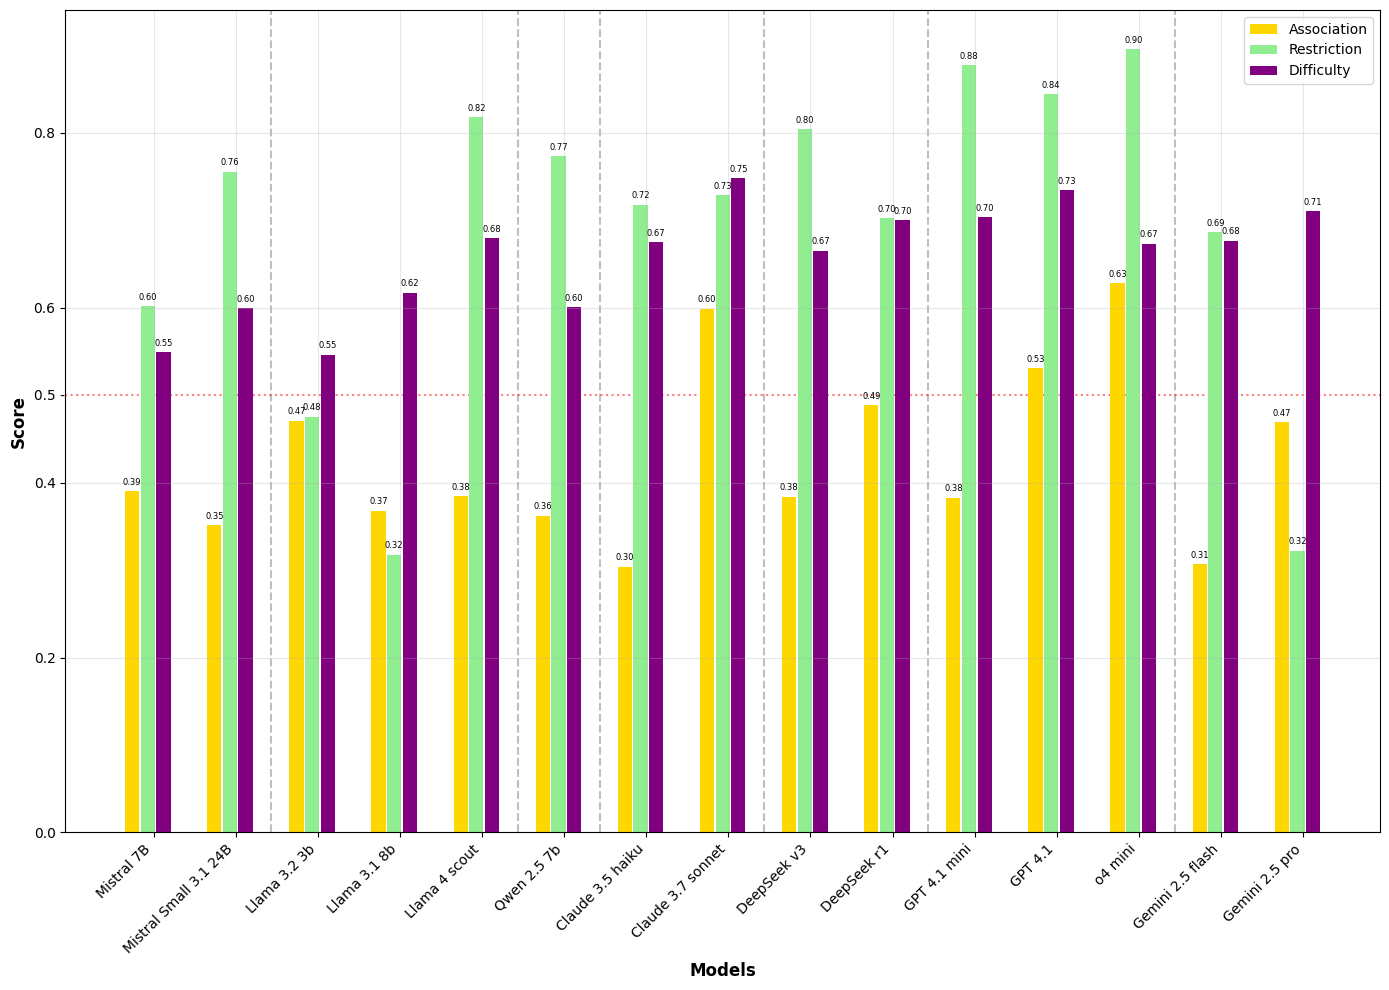

In [33]:
experiment_3['model'] = experiment_3['model_name'].str.replace('/', '-', regex=False)
# Merge the datasets based on model name
merged_exp = pd.merge(experiment_3[['model', 'avg_question_order_score']], 
                     experiment_1[['model','avg_benchmarks_Score','accuracy']], 
                     on='model', how='inner')
merged_exp = pd.merge(merged_exp,
                     experiment_2[['model','consistency_rate', 'overcuteness_rate']], 
                     on='model', how='inner')

# Sort and add company information
merged_exp_clean = merged_exp.copy()
merged_exp_clean["model"] = merged_exp["model"].apply(util.clean_model_name)
print(sorted_models)
merged_exp = util.sort_dataframe_by_company_model_order(merged_exp_clean, sorted_models)
merged_exp = pd.merge(
    merged_exp,
    sorted_models[['model', 'company']],
    on='model',
    how='left'
)
display(experiment_2)
# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Set width of bars
barWidth = 0.26
positions = np.arange(len(merged_exp))*1.5
offset = 0.09  # Offset for the bars to avoid overlap

# First, draw vertical separator lines BEFORE creating the bars
# This ensures they appear behind the bars
companies = merged_exp['company'].values
company_change_indices = []

# Find where company changes occur
for i in range(1, len(companies)):
    if companies[i] != companies[i-1]:
        company_change_indices.append(i)

# Draw separator lines at the correct positions between company groups
for idx in company_change_indices:
    # Calculate the correct x-position between groups
    separator_x = positions[idx-1] + barWidth*4.0  # Position after the last bar of previous group
    plt.axvline(x=separator_x, color='gray', linestyle='--', alpha=0.5, zorder=0)

plt.axhline(y=0.5, color='red', linestyle='dotted', alpha=0.5, zorder=1)
plt.text(-1.8, 0.4915, '0.5 -', fontsize=9.8, color='black', 
         verticalalignment='bottom', horizontalalignment='left')

# Create a mapping of old column names to new labels
label_mapping = {
    'avg_benchmarks_Score': 'General Ability',
    'accuracy': 'Association',
    'consistency_rate': 'Restriction',
    'avg_question_order_score': 'Difficulty',
    'performance_avg': 'Performance Avg'
}
# Create bars
bars1 = ax.bar(positions, merged_exp['accuracy'], barWidth,
               label='Association', color='gold')

bars2 = ax.bar(positions + barWidth*1.1, merged_exp['consistency_rate'], barWidth,
               label='Restriction', color='lightgreen')

bars3 = ax.bar(positions + barWidth*2.2, merged_exp['avg_question_order_score'], barWidth, 
               label='Difficulty', color='purple')

# bars4 = ax.bar(positions + barWidth*3.3, merged_exp['avg_benchmarks_Score'], barWidth,
#                label='Avg benchmarks Score', color='salmon')

# Add labels, title and legend
ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
# ax.set_title('Experiments Comparison', fontweight='bold', fontsize=14)
ax.set_xticks(positions + barWidth*1.5)  # Center the labels
ax.set_xticklabels(merged_exp['model'], rotation=45, ha='right')
ax.legend()

# Add value labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=6)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
# add_labels(bars4)

plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

## Compersion of all the Experiments

Model order mapping: {'Mistral 7B': 0, 'Mistral Small 3.1 24B': 1, 'Llama 3.2 3b': 2, 'Llama 3.1 8b': 3, 'Llama 4 scout': 4, 'Qwen 2.5 7b': 5, 'Claude 3.5 haiku': 6, 'Claude 3.7 sonnet': 7, 'DeepSeek v3': 8, 'DeepSeek r1': 9, 'GPT 4.1 mini': 10, 'GPT 4.1': 11, 'o4 mini': 12, 'Gemini 2.5 flash': 13, 'Gemini 2.5 pro': 14}
              model  adjusted_avg_question_order_score  avg_benchmarks_Score  \
0       Qwen 2.5 7b                           0.607834              0.030810   
1  Gemini 2.5 flash                           0.676667              1.790027   
2    Gemini 2.5 pro                           0.752597              2.164194   

   accuracy  consistency_rate  overcuteness_rate  sort_index  
0  0.362360          0.773333           0.980198           5  
1  0.306352          0.686667           0.983051          13  
2  0.469136          0.322222           0.588235          14  


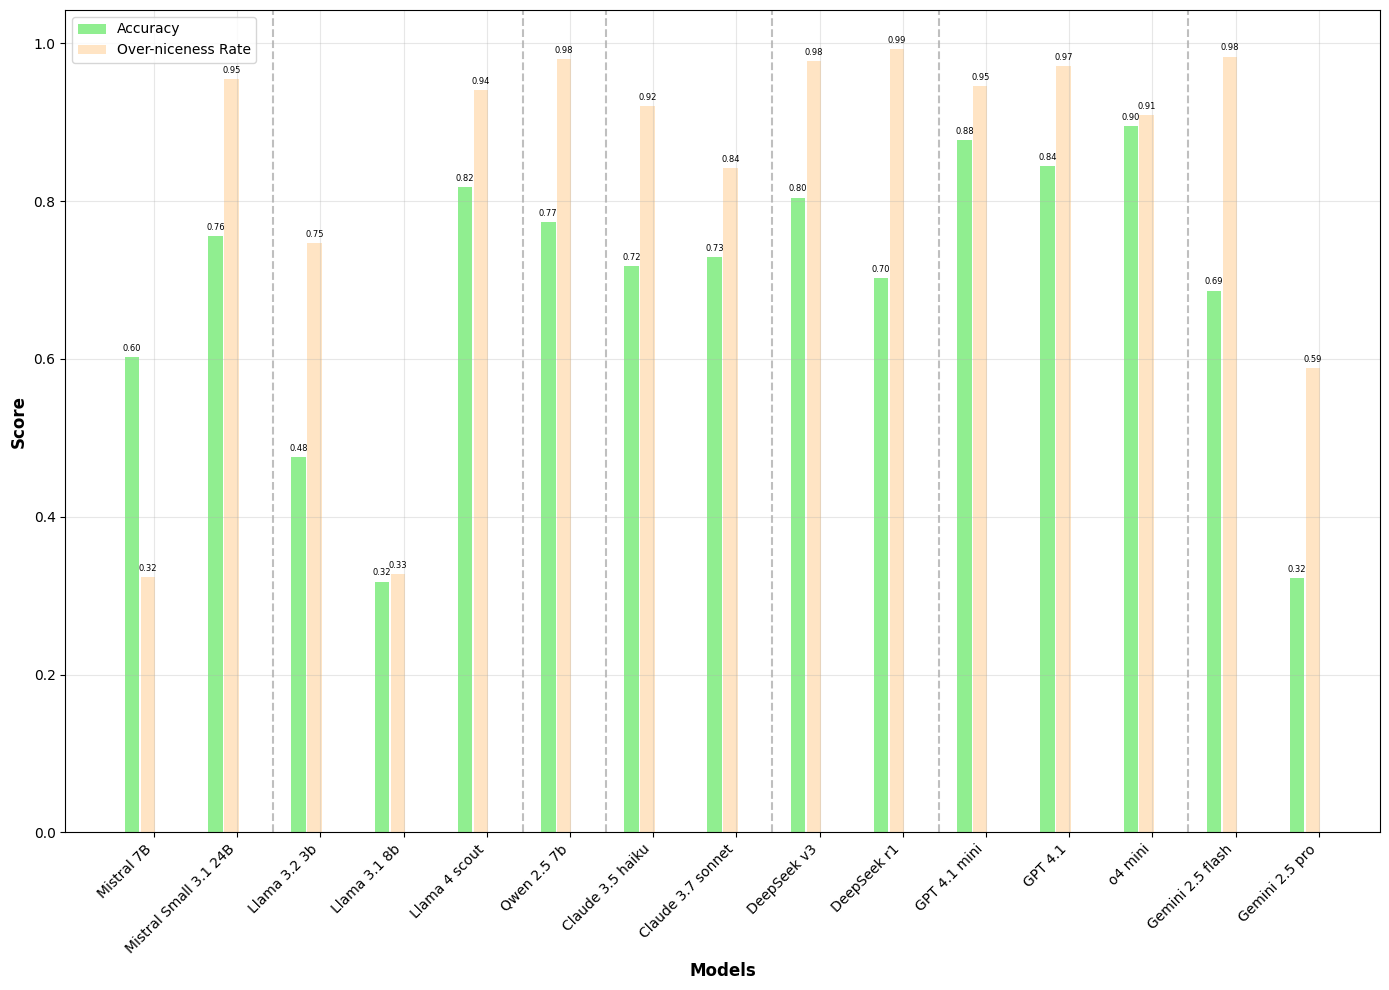

In [34]:
experiment_3['model'] = experiment_3['model_name'].str.replace('/', '-', regex=False)
# Merge the datasets based on model name
merged_exp = pd.merge(experiment_3[['model', 'adjusted_avg_question_order_score']], 
                     experiment_1[['model','avg_benchmarks_Score','accuracy']], 
                     on='model', how='inner')
merged_exp = pd.merge(merged_exp,
                     experiment_2[['model','consistency_rate', 'overcuteness_rate']], 
                     on='model', how='inner')

# Sort and add company information
merged_exp_clean = merged_exp.copy()
merged_exp_clean["model"] = merged_exp["model"].apply(util.clean_model_name)
# print(sorted_models)
merged_exp = util.sort_dataframe_by_company_model_order(merged_exp_clean, sorted_models)
merged_exp = pd.merge(
    merged_exp,
    sorted_models[['model', 'company']],
    on='model',
    how='left'
)
# display(experiment_2)
# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Set width of bars
barWidth = 0.26
positions = np.arange(len(merged_exp))*1.5
offset = 0.09  # Offset for the bars to avoid overlap

# First, draw vertical separator lines BEFORE creating the bars
# This ensures they appear behind the bars
companies = merged_exp['company'].values
company_change_indices = []

# Find where company changes occur
for i in range(1, len(companies)):
    if companies[i] != companies[i-1]:
        company_change_indices.append(i)

# Draw separator lines at the correct positions between company groups
for idx in company_change_indices:
    # Calculate the correct x-position between groups
    separator_x = positions[idx-1] + barWidth*4.0  # Position after the last bar of previous group
    plt.axvline(x=separator_x, color='gray', linestyle='--', alpha=0.5, zorder=0)

# Create bars
bars2 = ax.bar(positions , merged_exp['consistency_rate'], barWidth,
               label='Accuracy', color='lightgreen')


bars1 = ax.bar(positions+ barWidth*1.1, merged_exp['overcuteness_rate'], barWidth,
               label='Over-niceness Rate', color='bisque')


# bars3 = ax.bar(positions + barWidth*2.2, merged_exp['adjusted_avg_question_order_score'], barWidth, 
#                label='accuracy of experiment 3', color='skyblue')

# bars4 = ax.bar(positions + barWidth*3.3, merged_exp['avg_benchmarks_Score'], barWidth,
#                label='Avg benchmarks Score', color='salmon')

# Add labels, title and legend
ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
# ax.set_title('Experiment 2 statistics', fontweight='bold', fontsize=14)
ax.set_xticks(positions + barWidth*1.5)  # Center the labels
ax.set_xticklabels(merged_exp['model'], rotation=45, ha='right')
ax.legend()

# Add value labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=6)

add_labels(bars1)
add_labels(bars2)
# add_labels(bars3)
# add_labels(bars4)

plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

Model order mapping: {'Mistral 7B': 0, 'Mistral Small 3.1 24B': 1, 'Llama 3.2 3b': 2, 'Llama 3.1 8b': 3, 'Llama 4 scout': 4, 'Qwen 2.5 7b': 5, 'Claude 3.5 haiku': 6, 'Claude 3.7 sonnet': 7, 'DeepSeek v3': 8, 'DeepSeek r1': 9, 'GPT 4.1 mini': 10, 'GPT 4.1': 11, 'o4 mini': 12, 'Gemini 2.5 flash': 13, 'Gemini 2.5 pro': 14}
              model  avg_question_order_score  avg_benchmarks_Score  accuracy  \
0       Qwen 2.5 7b                  0.600540              0.030810  0.362360   
1  Gemini 2.5 flash                  0.676667              1.790027  0.306352   
2    Gemini 2.5 pro                  0.710452              2.164194  0.469136   

   consistency_rate  overcuteness_rate  sort_index  
0          0.773333           0.980198           5  
1          0.686667           0.983051          13  
2          0.322222           0.588235          14  
0     0.513738
1     0.568817
2     0.497577
3     0.434314
4     0.627365
5     0.578744
6     0.565475
7     0.691863
8     0.617940
9     

,model,avg_question_order_score,avg_benchmarks_Score,accuracy,consistency_rate,overcuteness_rate,company,performance_avg
0,Mistral 7B,0.549020,-0.967503,0.389972,0.602222,0.324022,mistralai,0.513738
1,Mistral Small 3.1 24B,0.599044,0.137102,0.351852,0.755556,0.954545,mistralai,0.568817
2,Llama 3.2 3b,0.546346,-0.685893,0.470828,0.475556,0.747253,meta,0.497577
3,Llama 3.1 8b,0.617257,-0.341314,0.367908,0.317778,0.327273,meta,0.434314
4,Llama 4 scout,0.679333,0.565294,0.384985,0.817778,0.941176,meta,0.627365
5,Qwen 2.5 7b,0.600540,0.030810,0.362360,0.773333,0.980198,qwen,0.578744
6,Claude 3.5 haiku,0.674667,0.353270,0.303982,0.717778,0.920000,anthropic,0.565475
7,Claude 3.7 sonnet,0.747826,1.814551,0.598873,0.728889,0.842105,anthropic,0.691863
8,DeepSeek v3,0.665333,1.026966,0.384041,0.804444,0.977011,deepseek,0.617940
9,DeepSeek r1,0.700000,1.721680,0.488189,0.702222,0.992537,deepseek,0.630137


,model,avg_question_order_score,avg_benchmarks_Score,accuracy,consistency_rate,overcuteness_rate,company,performance_avg
0,Mistral 7B,0.549020,-0.967503,0.389972,0.602222,0.324022,mistralai,0.513738
1,Mistral Small 3.1 24B,0.599044,0.137102,0.351852,0.755556,0.954545,mistralai,0.568817
2,Llama 3.2 3b,0.546346,-0.685893,0.470828,0.475556,0.747253,meta,0.497577
3,Llama 3.1 8b,0.617257,-0.341314,0.367908,0.317778,0.327273,meta,0.434314
4,Llama 4 scout,0.679333,0.565294,0.384985,0.817778,0.941176,meta,0.627365
5,Qwen 2.5 7b,0.600540,0.030810,0.362360,0.773333,0.980198,qwen,0.578744
6,Claude 3.5 haiku,0.674667,0.353270,0.303982,0.717778,0.920000,anthropic,0.565475
7,Claude 3.7 sonnet,0.747826,1.814551,0.598873,0.728889,0.842105,anthropic,0.691863
8,DeepSeek v3,0.665333,1.026966,0.384041,0.804444,0.977011,deepseek,0.617940
9,DeepSeek r1,0.700000,1.721680,0.488189,0.702222,0.992537,deepseek,0.630137


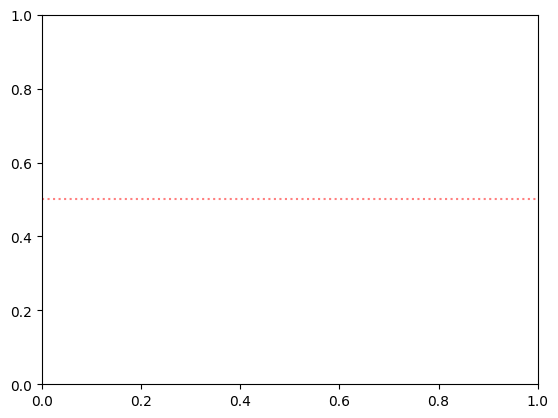

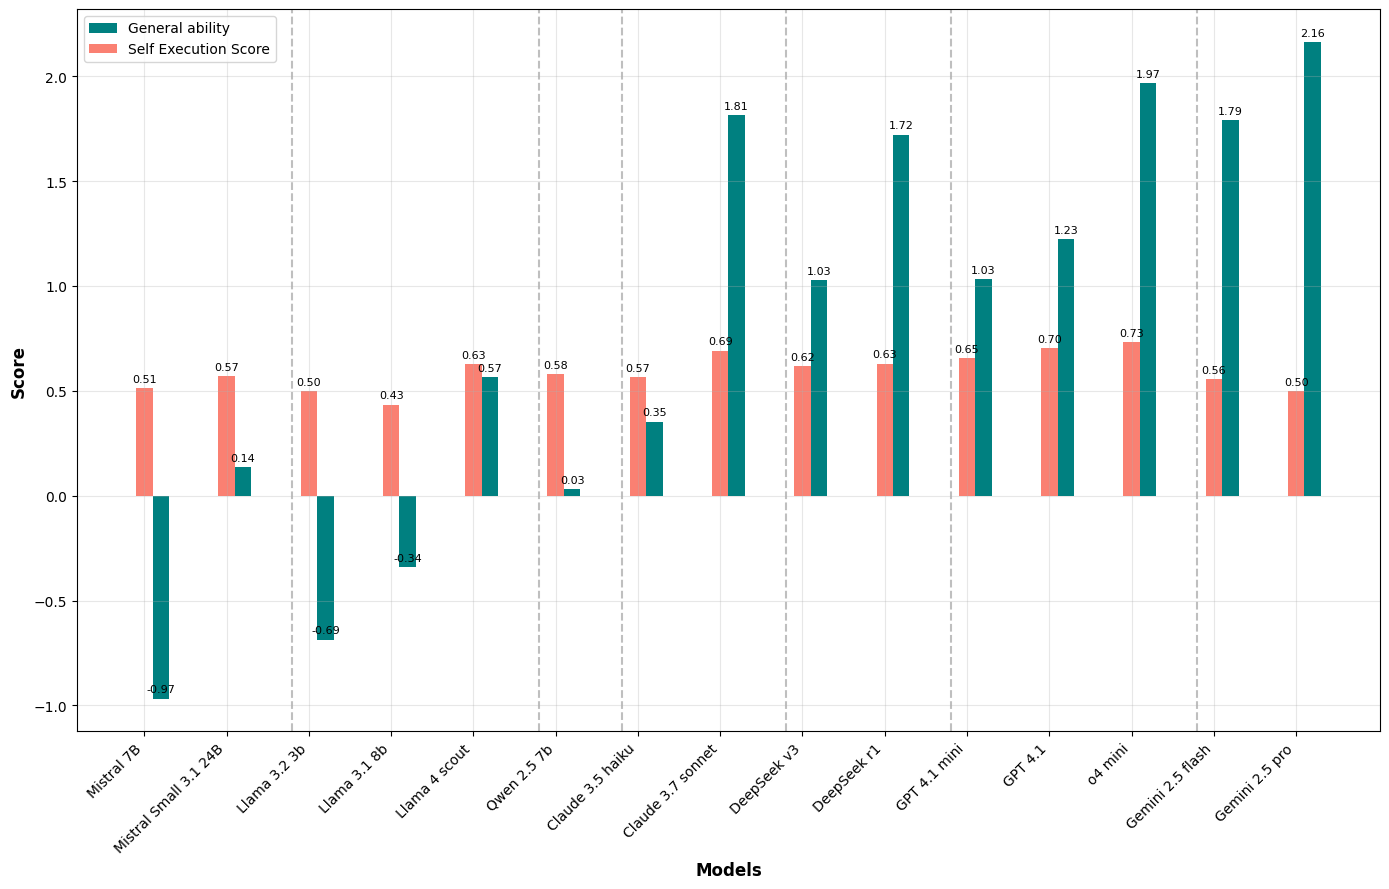

In [35]:
merged_exp = pd.merge(experiment_3[['model', 'avg_question_order_score']], 
                     experiment_1[['model','avg_benchmarks_Score','accuracy']], 
                     on='model', how='inner')
merged_exp = pd.merge(merged_exp,
                     experiment_2[['model','consistency_rate', 'overcuteness_rate']], 
                     on='model', how='inner')

# Sort and add company information
merged_exp_clean = merged_exp.copy()
merged_exp_clean["model"] = merged_exp["model"].apply(util.clean_model_name)
# print(sorted_models)
merged_exp = util.sort_dataframe_by_company_model_order(merged_exp_clean, sorted_models)
merged_exp = pd.merge(
    merged_exp,
    sorted_models[['model', 'company']],
    on='model',
    how='left'
)
# # Calculate the average of the three metrics (consistency_rate, avg_question_order_score, accuracy)
merged_exp['performance_avg'] = (merged_exp['consistency_rate'] + 
                               merged_exp['avg_question_order_score'] + 
                               merged_exp['accuracy']) / 3
print(merged_exp['performance_avg'], " : consistency=", merged_exp['consistency_rate'],
                               "order rate", merged_exp['avg_question_order_score'],
                               merged_exp['accuracy'], " : ", merged_exp['model'])
display(merged_exp)
# Sort by the average performance for better visualization
# merged_df = merged_exp.sort_values(by='performance_avg', ascending=True)
merged_df = merged_exp

plt.axhline(y=0.5, color='red', linestyle='dotted', alpha=0.5, zorder=1)

# Display the dataframe with the new average metric
display(merged_df)


# Create the plot
fig, ax = plt.subplots(figsize=(14, 9))

# Set width of bars
barWidth = 0.2
positions = np.arange(len(merged_exp))

# Create bars

bars1 = ax.bar(positions + barWidth, merged_exp['avg_benchmarks_Score'], barWidth,
                label='General ability', color='teal')

bars2 = ax.bar(positions, merged_df['performance_avg'] , barWidth, 
              label='Self Execution Score', color='salmon')

# Add labels, title and legend
ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
# ax.set_title('Comparison of Models Scores Across Experiments', fontweight='bold', fontsize=14)
ax.set_xticks(positions)
ax.set_xticklabels(merged_exp['model'], rotation=45, ha='right')
ax.legend()

# Add value labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# First, draw vertical separator lines BEFORE creating the bars
# This ensures they appear behind the bars
companies = merged_exp['company'].values
company_change_indices = []

# Find where company changes occur
for i in range(1, len(companies)):
    if companies[i] != companies[i-1]:
        company_change_indices.append(i)        
# Draw separator lines at the correct positions between company groups
for idx in company_change_indices:
    # Calculate the correct x-position between groups
    separator_x = positions[idx-1] + barWidth*4.0  # Position after the last bar of previous group
    plt.axvline(x=separator_x, color='gray', linestyle='--', alpha=0.5, zorder=0)        

add_labels(bars1)
add_labels(bars2)


plt.tight_layout()
plt.grid(True, alpha=0.3)
# plt.show()

In [36]:
temp = merged_exp[['model', 'avg_benchmarks_Score', 'performance_avg']].copy()
temp['avg_benchmarks_Score'] = temp['avg_benchmarks_Score']-0.5
display(temp[['model','avg_benchmarks_Score']])

,model,avg_benchmarks_Score
0,Mistral 7B,-1.467503
1,Mistral Small 3.1 24B,-0.362898
2,Llama 3.2 3b,-1.185893
3,Llama 3.1 8b,-0.841314
4,Llama 4 scout,0.065294
5,Qwen 2.5 7b,-0.469190
6,Claude 3.5 haiku,-0.146730
7,Claude 3.7 sonnet,1.314551
8,DeepSeek v3,0.526966
9,DeepSeek r1,1.221680


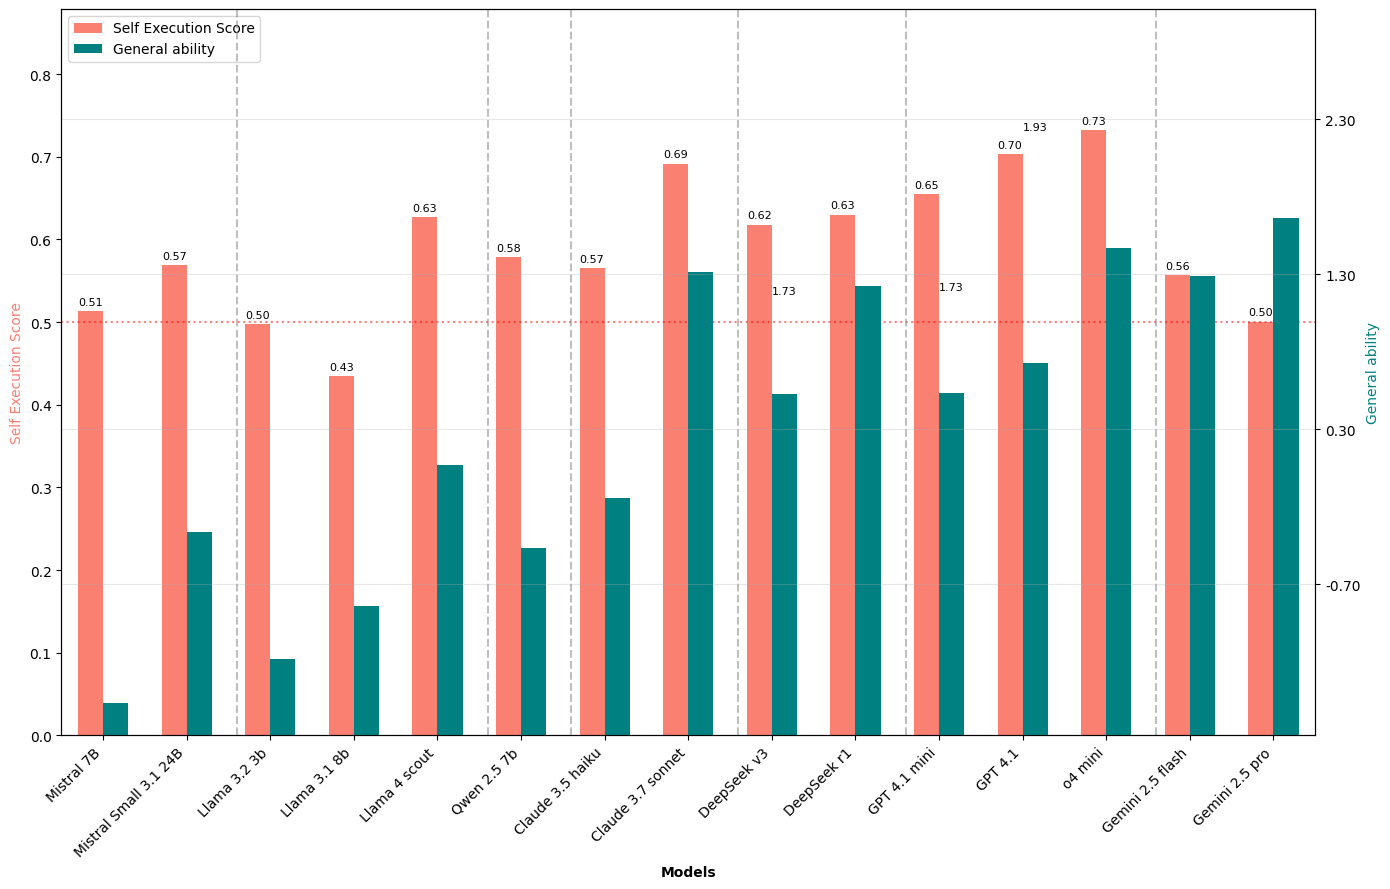

In [96]:
from matplotlib.ticker import FuncFormatter


merged_df = merged_exp.copy()

merged_df['avg_benchmarks_Score'] = merged_df['avg_benchmarks_Score'] - 0.5

# הנתונים:
models = merged_df['model']
perf   = merged_df['performance_avg']       # חיובי
bench  = merged_df['avg_benchmarks_Score']  # שלילי (לפני הזזה)

# קובעים אופסט של +0.5
offset     = 1.7
bench_plot = bench + offset

x     = np.arange(len(models))
width = 0.30

fig, ax1 = plt.subplots(figsize=(14,9))
ax2 = ax1.twinx()

#the positive bars
bars_perf = ax1.bar(
    x - width/2, perf, width,
    label='Self Execution Score',
    color='salmon'
)

# the negative bars (shifted up by offset) 
bars_bench = ax2.bar(
    x + width/2, bench_plot, width,
    label='General ability',
    color='teal'
)

# 3. מגדירים את טווח הצירים
ax1.set_ylim(0, perf.max() * 1.2)
ax2.set_ylim((bench + offset).min() * 0.1, (bench + offset).max() * 1.4)

# 4. פורמטור לתוויות ציר ימין שמחזיר את הטיק־לייבל לערך המקורי (לפני הזזה)
ax2.yaxis.set_major_formatter(
    FuncFormatter(lambda val, pos: f'{val - offset:.2f}')
)

ax1.set_xlabel('Models', fontweight='bold')
ax1.set_ylabel('Self Execution Score', color='salmon')
ax2.set_ylabel('General ability', color='teal')

ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

# Draw separator lines at the correct positions between company groups
for idx in company_change_indices:
    # Calculate the correct x-position between groups
    separator_x = positions[idx-1] + barWidth*3 # Position after the last bar of previous group
    plt.axvline(x=separator_x, color='gray', linestyle='--', alpha=0.5, zorder=0)


plt.grid(alpha=0.3)
plt.tight_layout()
ax1.axhline(y=0.5, color='red', linestyle='dotted', alpha=0.5, zorder=1)

ax1.set_xlim(-0.5, len(models)-0.5)

# Add value labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height-0.5:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height-offset),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# Add value labels on the bars
def add_labels2(bars):
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)


add_labels2(bars_perf)
add_labels(bars_bench)

ax1.margins(x=0.02)

ax1.relim()
ax1.autoscale_view()

plt.show()

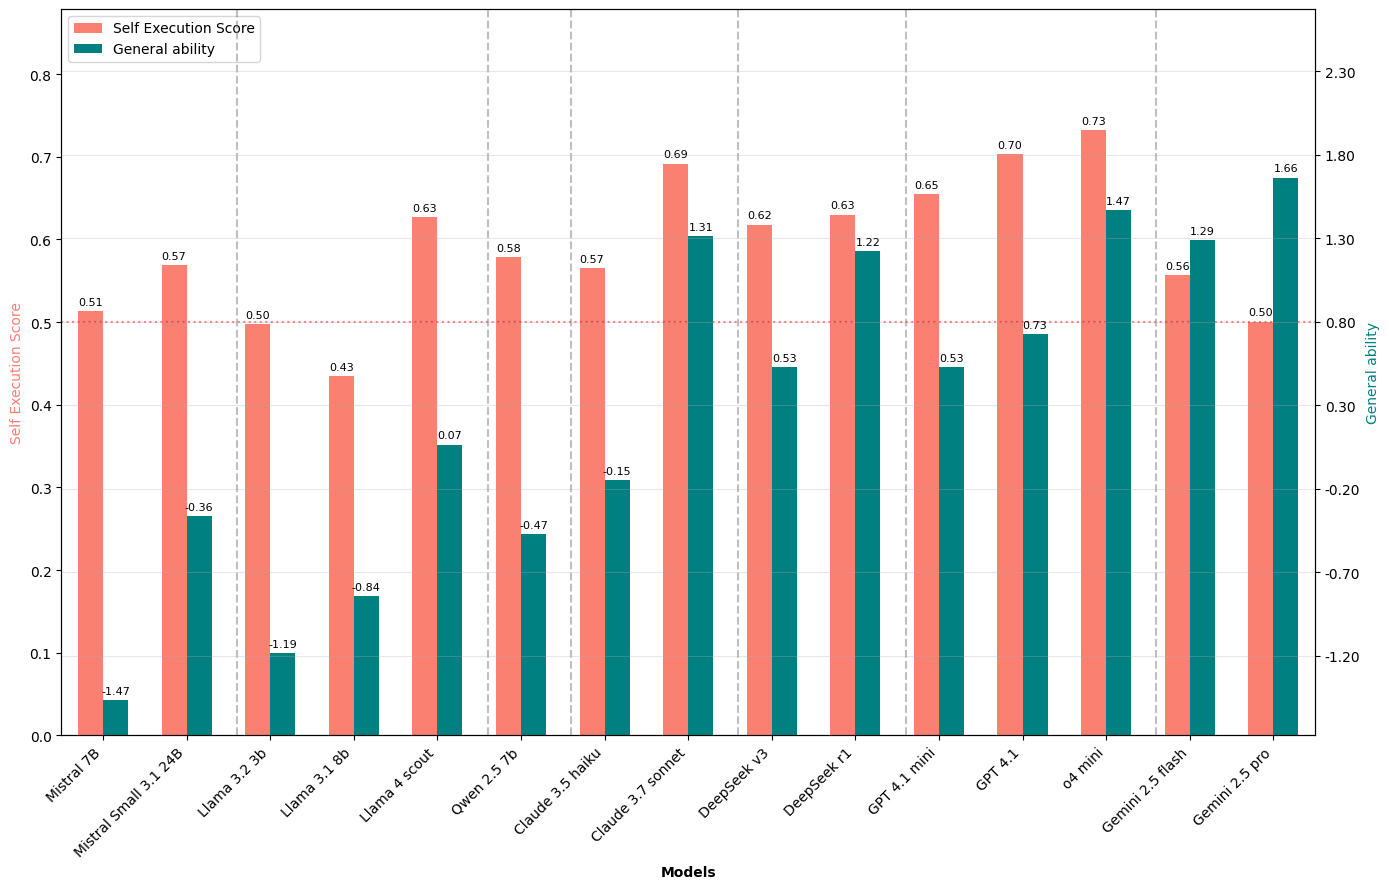

In [100]:
from matplotlib.ticker import FuncFormatter

merged_df = merged_exp.copy()

merged_df['avg_benchmarks_Score'] = merged_df['avg_benchmarks_Score'] - 0.5

# הנתונים:
models = merged_df['model']
perf   = merged_df['performance_avg']       # חיובי
bench  = merged_df['avg_benchmarks_Score']  # שלילי (לפני הזזה)

# קובעים אופסט של +0.5
offset     = 1.7
bench_plot = bench + offset

x     = np.arange(len(models))
width = 0.30

fig, ax1 = plt.subplots(figsize=(14,9))
ax2 = ax1.twinx()

#the positive bars
bars_perf = ax1.bar(
    x - width/2, perf, width,
    label='Self Execution Score',
    color='salmon'
)

# the negative bars (shifted up by offset) 
bars_bench = ax2.bar(
    x + width/2, bench_plot, width,
    label='General ability',
    color='teal'
)

# 3. מגדירים את טווח הצירים
ax1.set_ylim(0, perf.max() * 1.2)
ax2.set_ylim((bench + offset).min() * 0.1, (bench + offset).max() * 1.3)

# 4. פורמטור לתוויות ציר ימין שמחזיר את הטיק־לייבל לערך המקורי (לפני הזזה)
ax2.yaxis.set_major_formatter(
    FuncFormatter(lambda val, pos: f'{val - offset:.2f}')
)

ax1.set_xlabel('Models', fontweight='bold')
ax1.set_ylabel('Self Execution Score', color='salmon')
ax2.set_ylabel('General ability', color='teal')

ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

# Draw separator lines at the correct positions between company groups
for idx in company_change_indices:
    # Calculate the correct x-position between groups
    separator_x = positions[idx-1] + barWidth*3 # Position after the last bar of previous group
    plt.axvline(x=separator_x, color='gray', linestyle='--', alpha=0.5, zorder=0)

plt.grid(alpha=0.3)
plt.tight_layout()
ax1.axhline(y=0.5, color='red', linestyle='dotted', alpha=0.5, zorder=1)

ax1.set_xlim(-0.5, len(models)-0.5)

# Add value labels on the benchmark bars (teal bars) - corrected
def add_labels_bench(bars, original_values):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        # Display the original benchmark score (before offset)
        ax2.annotate(f'{original_values.iloc[i]:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# Add value labels on the performance bars (salmon bars)
def add_labels_perf(bars):
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# Apply the labels
add_labels_perf(bars_perf)
add_labels_bench(bars_bench, bench)

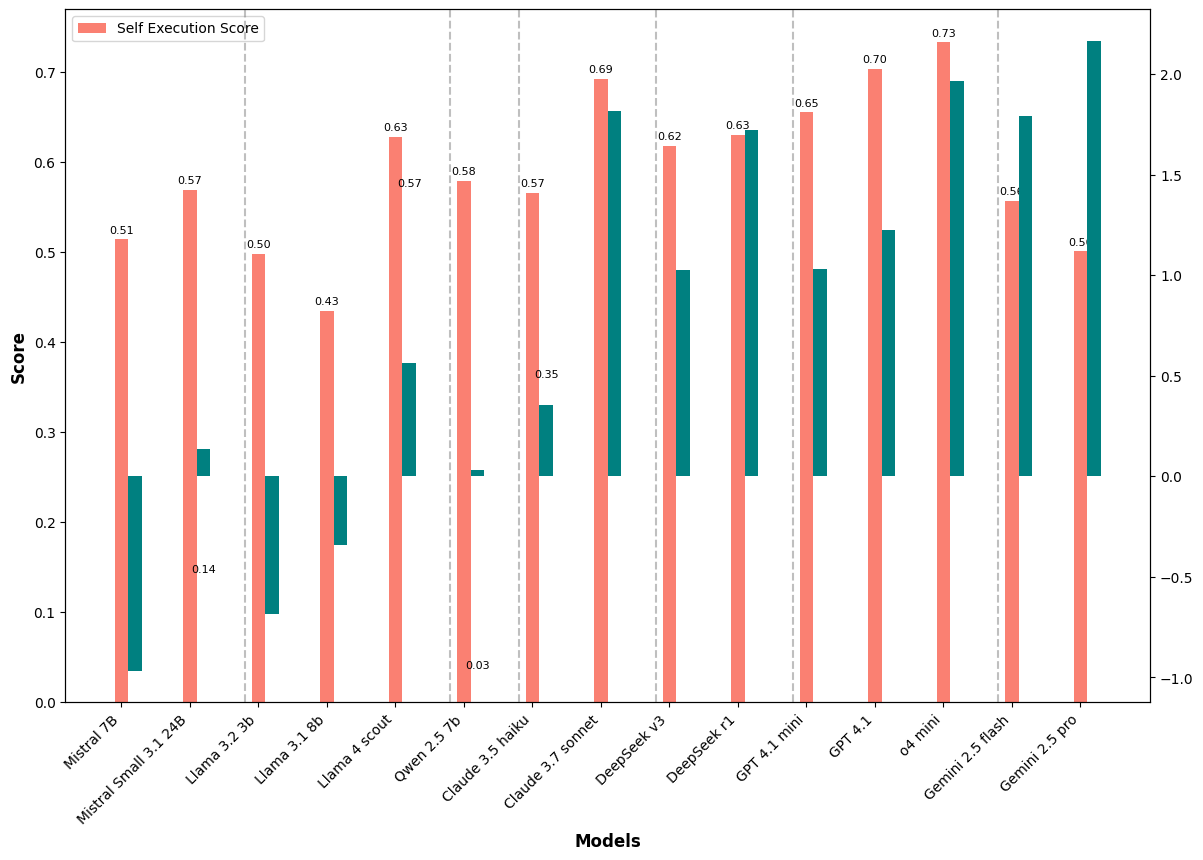

In [38]:

# Sort by the average performance for better visualization
# merged_df = merged_exp.sort_values(by='performance_avg', ascending=True)
merged_df = merged_exp.copy()

merged_df['avg_benchmarks_Score'] = merged_df['avg_benchmarks_Score'] - 0.5

# Create the plot
fig, ax = plt.subplots(figsize=(14, 9))

# Set width of bars
barWidth = 0.2
positions = np.arange(len(merged_df))

ax2 = ax.twinx()  # Create a second y-axis

# Create bars

bars1 = ax2.bar(positions + barWidth, merged_exp['avg_benchmarks_Score'], barWidth,
                label='General ability', color='teal')

bars2 = ax.bar(positions, merged_df['performance_avg'] , barWidth, 
              label='Self Execution Score', color='salmon')

# Add labels, title and legend
ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
# ax.set_title('Comparison of Models Scores Across Experiments', fontweight='bold', fontsize=14)
ax.set_xticks(positions)
ax.set_xticklabels(merged_df['model'], rotation=45, ha='right')
ax.legend()

# Add value labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# First, draw vertical separator lines BEFORE creating the bars
# This ensures they appear behind the bars
companies = merged_df['company'].values
company_change_indices = []

# Find where company changes occur
for i in range(1, len(companies)):
    if companies[i] != companies[i-1]:
        company_change_indices.append(i)        
# Draw separator lines at the correct positions between company groups
for idx in company_change_indices:
    # Calculate the correct x-position between groups
    separator_x = positions[idx-1] + barWidth*4.0  # Position after the last bar of previous group
    plt.axvline(x=separator_x, color='gray', linestyle='--', alpha=0.5, zorder=0)        

add_labels(bars1)
add_labels(bars2)


# plt.tight_layout()
# plt.grid(True, alpha=0.3)
# # plt.show()

In [39]:
mask = merged_exp[merged_exp['model'].isin(['Gemini 2.5 pro','o4 mini','Claude 3.7 sonnet','DeepSeek r1'])]
mask_comp = merged_exp['model'].isin(['GPT 4.1','Gemini 2.5 flash','DeepSeek v3','Claude 3.5 haiku'])
print("reasoning average: ", mask['avg_benchmarks_Score'].mean())
print("non reasoning average: ", merged_exp[mask_comp]['avg_benchmarks_Score'].mean())
print("\n\nperformance average\n")

print("reasoning average: ", mask['performance_avg'].mean())
print("non reasoning average: ", merged_exp[mask_comp]['performance_avg'].mean())

reasoning average:  1.91684925
non reasoning average:  1.0989515


performance average

reasoning average:  0.6387455743695168
non reasoning average:  0.6107734059086989


In [40]:
# # Scatter plot: avg_benchmarks_Score vs. Experiment 3 accuracy (adjusted_avg_question_order_score) with linear regression line
# import numpy as np
# from numpy.polynomial.polynomial import Polynomial
# plt.figure(figsize=(10, 7))
# x = merged_exp['avg_benchmarks_Score']
# y = merged_exp['adjusted_avg_question_order_score']
# plt.scatter(x, y, s=100, alpha=0.7)
# for i, row in merged_exp.iterrows():
#     plt.annotate(row['model'], (row['avg_benchmarks_Score'], row['adjusted_avg_question_order_score']), fontsize=9, xytext=(5, 2), textcoords='offset points')
# # Linear regression fit
# coefs = np.polyfit(x, y, 1)
# poly1d_fn = np.poly1d(coefs)
# plt.plot(x, poly1d_fn(x), color='red', linestyle='--', label='Linear Trendline')
# plt.xlabel('Avg Benchmarks Score')
# plt.ylabel('Experiment 3 Accuracy')
# plt.title('Avg Benchmarks Score vs. Experiment 3 Accuracy')
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [41]:
# import seaborn as sns

# # Select the relevant columns for correlation analysis
# correlation_data = merged_exp[['adjusted_avg_question_order_score', 
#                             'accuracy', 'consistency_rate', 'avg_benchmarks_Score','performance_avg']].copy()

# # Rename columns for better readability in the plot
# correlation_data = correlation_data.rename(columns={
#     'adjusted_avg_question_order_score': 'Exp3: Order Score',
#     'avg_benchmarks_Score': 'Benchmark Score',
#     'accuracy': 'Exp1: Word Association',
#     'consistency_rate': 'Exp2: Consistency',
#     'performance_avg': 'Performance Avg'
# })

# # Calculate the correlation matrix
# corr_matrix = correlation_data.corr()

# # Create a heatmap visualization
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
#             square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
# plt.title('Correlation Heatmap: Experiment Metrics and Benchmark Scores', fontsize=16)
# plt.tight_layout()
# plt.show()

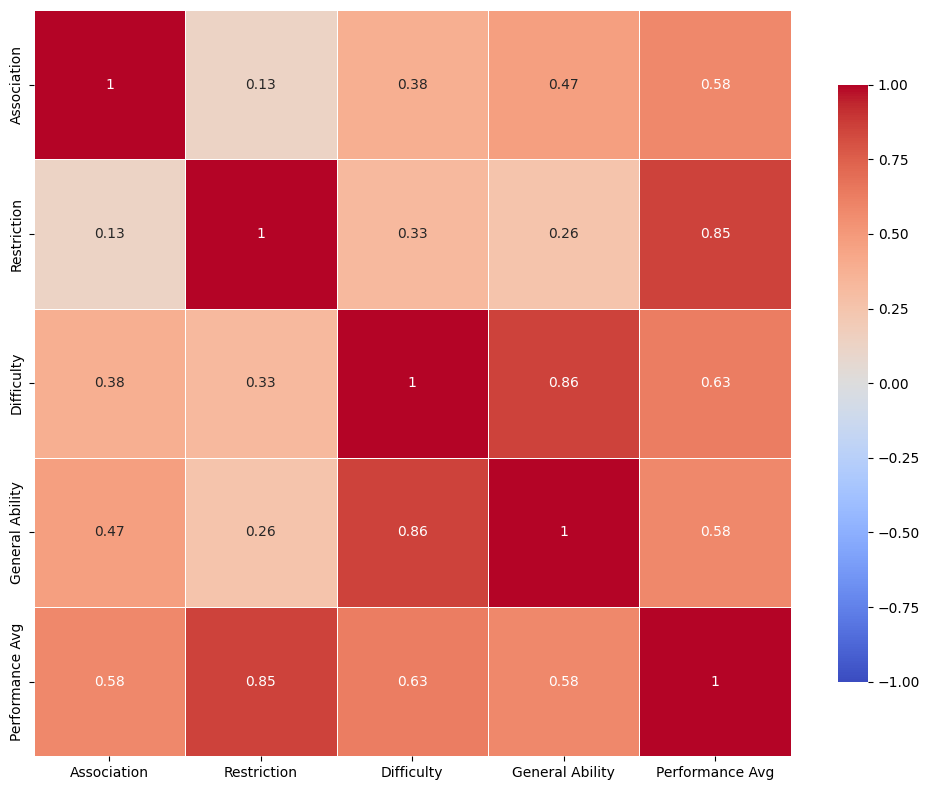

In [101]:
import seaborn as sns

# Original selection
correlation_data = merged_exp[['avg_question_order_score', 
                            'accuracy', 'consistency_rate', 'avg_benchmarks_Score', 'performance_avg']].copy()

# Rename columns
correlation_data = correlation_data.rename(columns={
    'avg_benchmarks_Score': 'General Ability',
    'accuracy': 'Association',
    'consistency_rate': 'Restriction',
    'avg_question_order_score': 'Difficulty',
    'performance_avg': 'Performance Avg'
})

# Calculate the correlation matrix
corr_matrix = correlation_data.corr()

# Define the new order you want
new_order = ['Association', 'Restriction', 'Difficulty', 'General Ability', 'Performance Avg']

# Reindex the correlation matrix with the new order
corr_matrix = corr_matrix.reindex(index=new_order, columns=new_order)  # Reverse the order for columns

# Create the heatmap with the reordered matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=False, linewidths=0.5, cbar_kws={"shrink": 0.8})
# plt.title('Correlation Heatmap: Experiment Metrics and Benchmark Scores', fontsize=16)
plt.tight_layout()
plt.show()